In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
data_root = "./data/montly"

# 데이터 과학 입문 Project

## 1. Data 준비

### 1) Weather data

In [3]:
# 파일 불러오기
weather_df = pd.read_csv(f'{data_root}/weather_df.csv', encoding='cp949')

# 일시 format 통일을 위한 변경 (ex :2000.01 -> 2000-01)
weather_df['시점'] = weather_df['시점'].astype('str').str.replace(pat='.', repl='-', regex=False)

# 분석에 필요없는 변수 제거
weather_df = weather_df.drop(['관측지점별', '최고기온','최저기온'],axis=1)
display(weather_df.head(10))

,시점,평균기온,합계강수량,평균풍속,평균상대습도,합계일조시간
0,2000-01,-2.1,42.8,2.6,64,108.3
1,2000-02,-1.7,2.1,2.7,56,139.3
2,2000-03,6.3,3.1,3.0,55,152.8
3,2000-04,11.9,30.7,2.9,56,156.6
4,2000-05,17.5,75.2,2.3,66,138.3
5,2000-06,23.7,68.1,1.9,65,133.0
6,2000-07,26.8,114.7,2.1,73,108.2
7,2000-08,26.2,599.4,1.7,79,112.8
8,2000-09,20.7,178.5,1.7,71,116.4
9,2000-1,14.9,18.1,1.5,64,131.3


### 2) 상품군별_판매액지수

In [4]:
product_df = pd.read_csv(f'{data_root}/재별및상품군별_판매액지수.csv', encoding='cp949', index_col=0).T
product_df.columns = [product_df.columns, product_df.loc['항목']]  # multi column으로 변경 (상품군 , 지수종류)
product_df = product_df.drop(index=['항목','단위'])

display(product_df.head(3))

총지수              총지수(승용차 제외)               내구재                승용차  \
항목         경상지수  불변지수 계절조정지수        경상지수 불변지수 계절조정지수  경상지수  불변지수 계절조정지수  경상지수   
1995.01 월  32.0  49.8   48.9         NaN  NaN    NaN  44.7  30.0   34.5  28.6   
1995.02 월  27.2  42.1   46.0         NaN  NaN    NaN  40.0  27.0   33.9  23.3   
1995.03 월  30.2  46.4   46.3         NaN  NaN    NaN  46.8  31.4   34.1  28.8   

           ...    화장품 서적, 문구             차량연료             기타비내구재              
항목         ... 계절조정지수   경상지수 불변지수 계절조정지수 경상지수 불변지수 계절조정지수   경상지수 불변지수 계절조정지수  
1995.01 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.02 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.03 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  

[3 rows x 72 columns]

- **지수 종류 및 column 선택**
    - 지수 종류 [경상지수, 불변지수, 계절조정지수]

In [5]:
# 사용할 컬럼 선택
product_sales_type = '불변지수'
product_columns = ['승용차', '가전제품','가구','의복', '가방', '음식료품','의약품','화장품', '서적, 문구']
product_column_sales_type = [(p, product_sales_type) for p in product_columns]
selected_product_df = product_df[product_column_sales_type].apply(pd.to_numeric)

# index 변경 및 일시 데이터 컬럼 생성, format 변환
selected_product_df['시점'] = selected_product_df.index.map(lambda x:f"{x[0:4]}-{x[5:7]:0<2}")
selected_product_df = selected_product_df.reset_index(drop=True)
selected_product_df.columns = [c[0] for c in selected_product_df.columns]

### 3) 데이터 합치기

In [6]:
df_dict = {}

for p in product_columns:
    tmp_df = selected_product_df[[p]+['시점']]
    merged_df = pd.merge(weather_df, tmp_df).dropna()
    merged_df = merged_df.reset_index(drop=True)
    df_dict[p] = merged_df
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')

상품군 승용차의 데이터 크기 : (245, 7)
상품군 가전제품의 데이터 크기 : (190, 7)
상품군 가구의 데이터 크기 : (190, 7)
상품군 의복의 데이터 크기 : (190, 7)
상품군 가방의 데이터 크기 : (135, 7)
상품군 음식료품의 데이터 크기 : (190, 7)
상품군 의약품의 데이터 크기 : (190, 7)
상품군 화장품의 데이터 크기 : (190, 7)
상품군 서적, 문구의 데이터 크기 : (190, 7)


### 4) Classification Target Data 구성 (높은 판매지수:1, 낮은 판매지수:0)

In [7]:
# 년 평균 판매지수 대비 높은지 여부 (높음:1, 낮음 :0)
for p in product_columns:
    df_dict[p]['연도'] = df_dict[p]['시점'].str[:4]
    yearly_means = df_dict[p].groupby('연도')[p].mean()
    increase_label_list = []
    for i in df_dict[p]['연도'].unique():
        increase_label_list.extend(df_dict[p][p].loc[df_dict[p]['연도']==i]>int(yearly_means[i]))
    df_dict[p]['년평균대비증감'] = increase_label_list
    df_dict[p]['년평균대비증감'] = df_dict[p]['년평균대비증감'].astype('int')
    
    # 필요없는 '연도' column 버리기
    df_dict[p] = df_dict[p].drop(['연도'],axis=1)
    df_dict[p].columns = ['time', 'temp', 'precip', 'wind', 'humid', 'sun', 'sales','sales_increase'] 
    

## 2. Data분석
### 2.1  Weather , Retail data

- **Histogram**

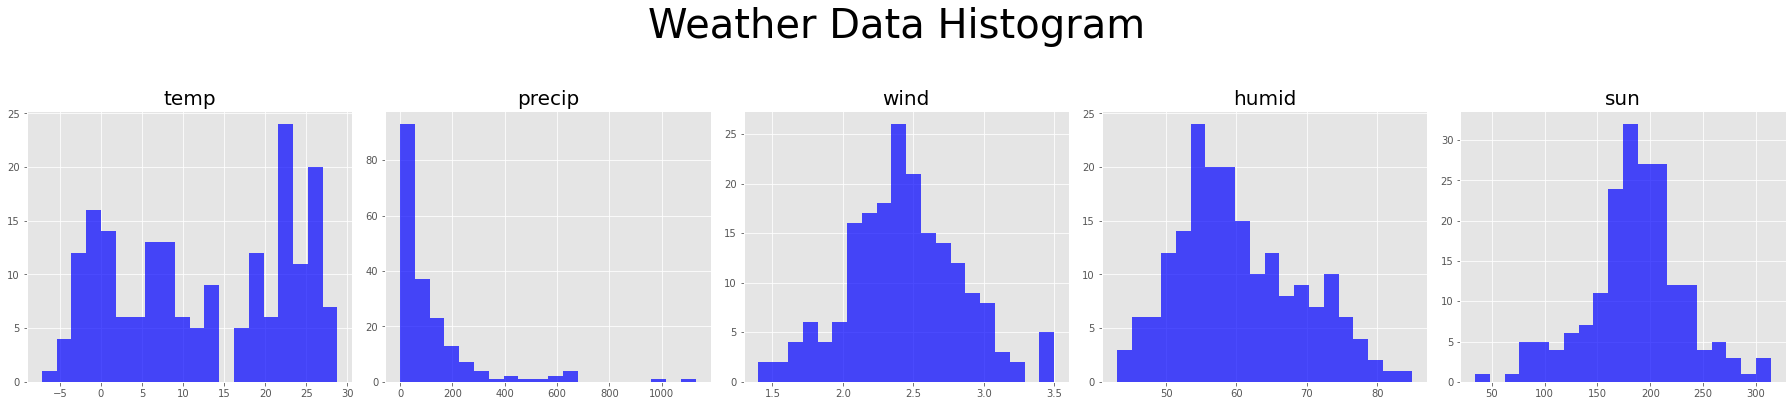

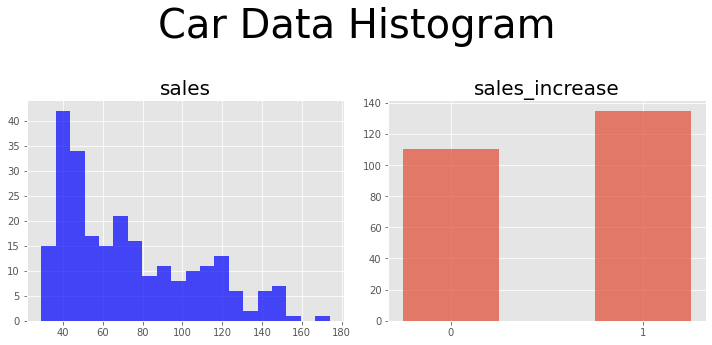

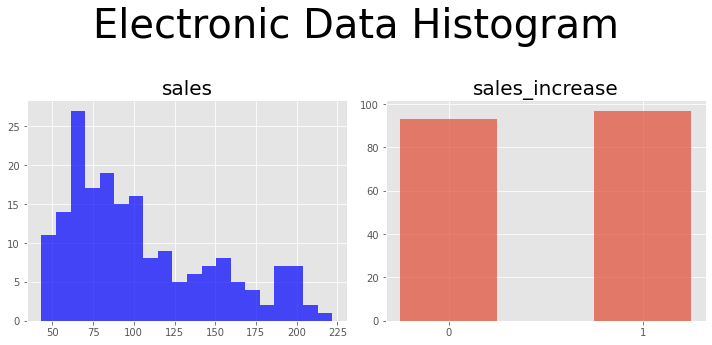

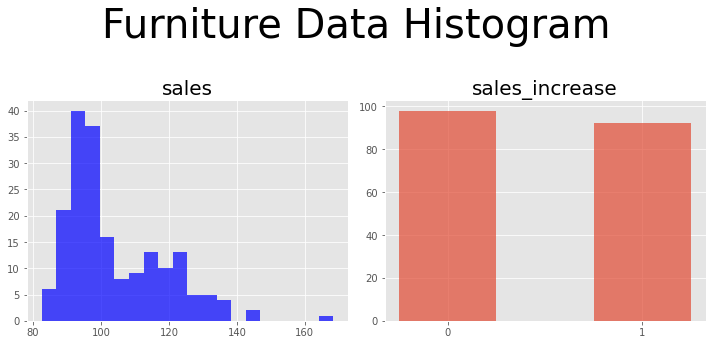

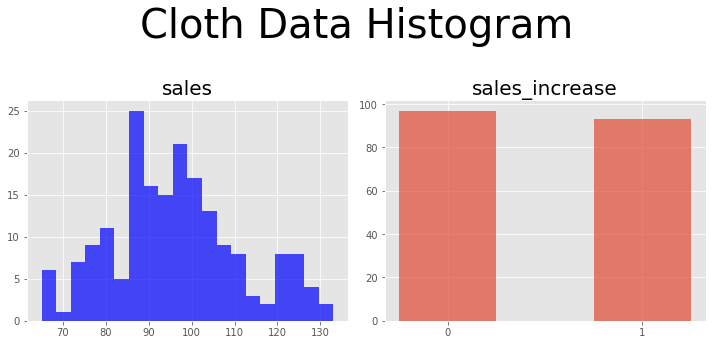

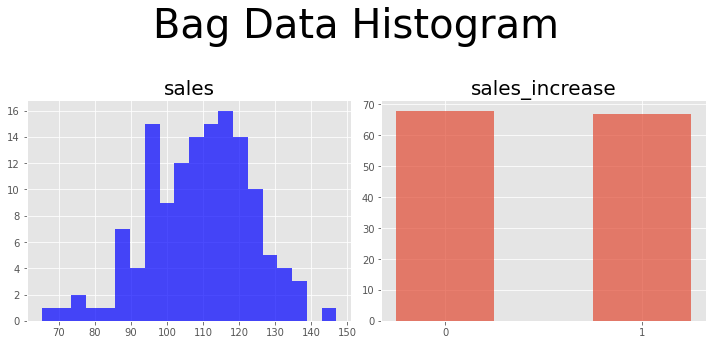

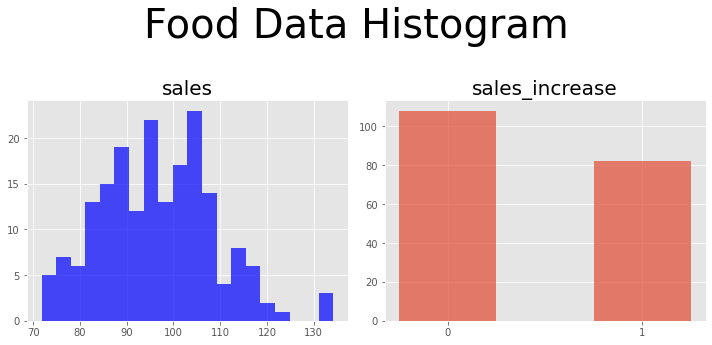

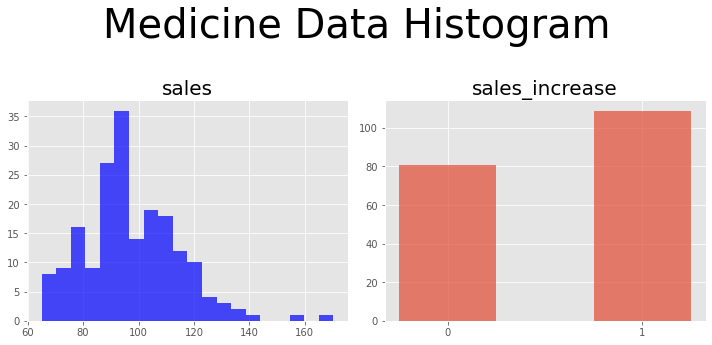

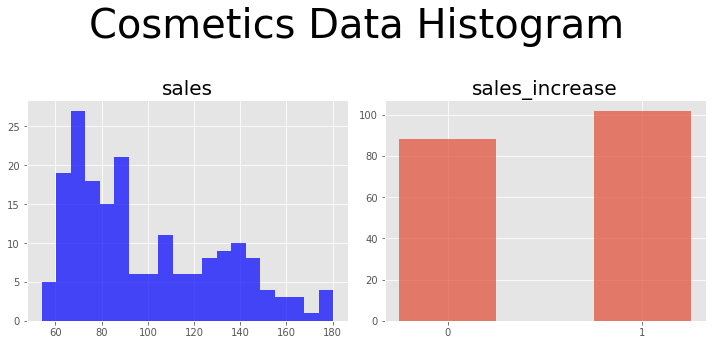

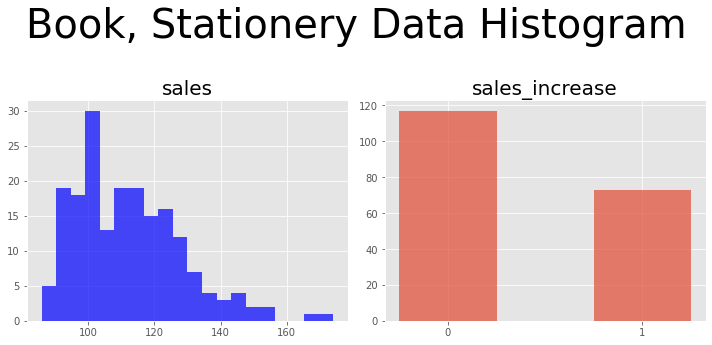

In [8]:
def plot_histogram(df, title: str = "Data Histogram"):

    cols = df.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    plt.style.use("ggplot")
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{title}", fontsize=40)

    i=0
    for col in cols:
        if type(df[col][0]) is str:
            continue
        i+=1
        plt.subplot(len_row,len_col,i)
        plt.title(col, fontsize=20)
        if len(df[col].unique()) > 3:
            plt.hist(df[col], bins=20, color='b', alpha=0.7)
        else:
            temp = df[col].value_counts()
            plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
            plt.xticks(temp.keys())
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

product_list = ['Car', 'Electronic','Furniture','Cloth', 'Bag', 'Food','Medicine','Cosmetics', 'Book, Stationery']

# 날씨 데이터 히스토그램
plot_histogram(df_dict[p][['temp', 'precip', 'wind', 'humid', 'sun']], title='Weather Data Histogram')

# 판매지수 및 판매지수 증감 데이터 히스토그램
for i,p in enumerate(product_columns):
    plot_histogram(df_dict[p][['sales','sales_increase']], title=f'{product_list[i]} Data Histogram')

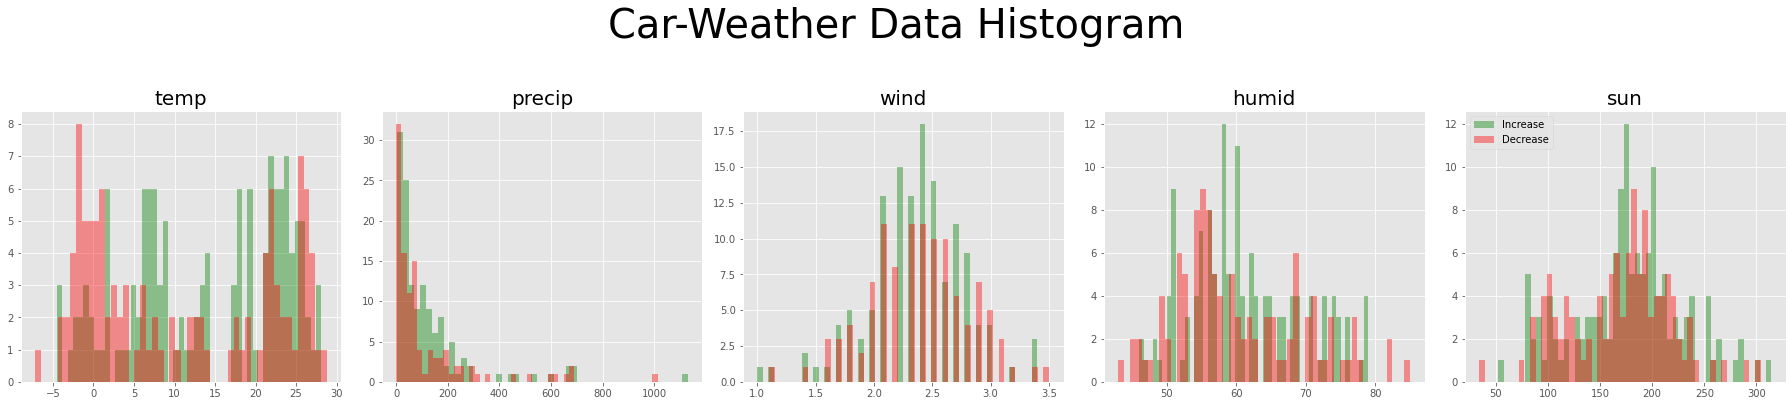

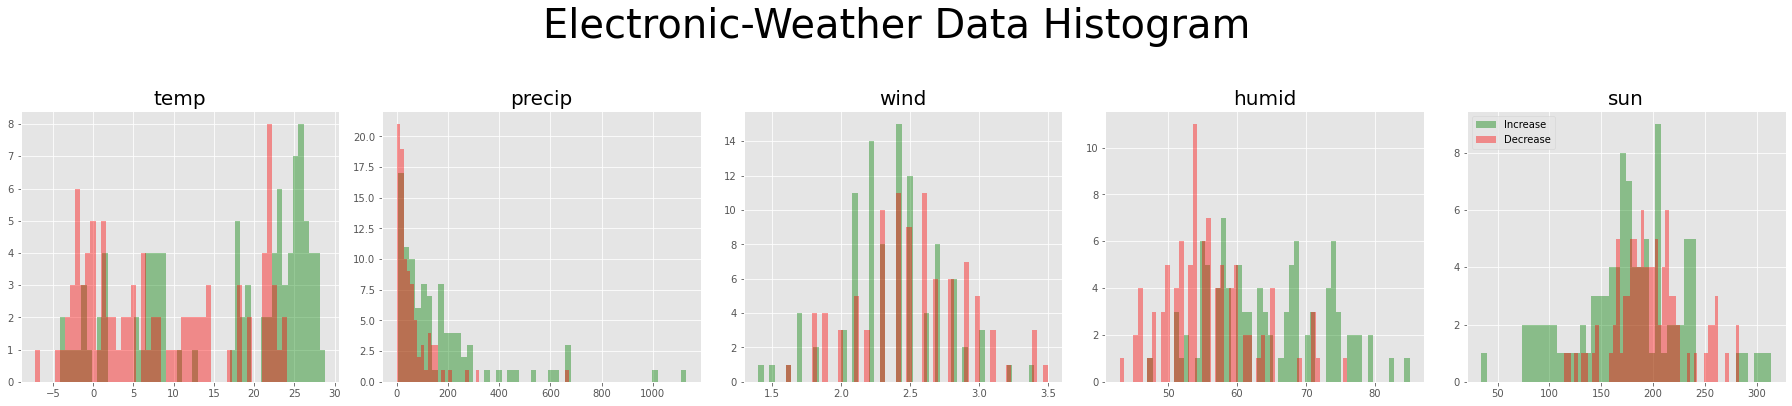

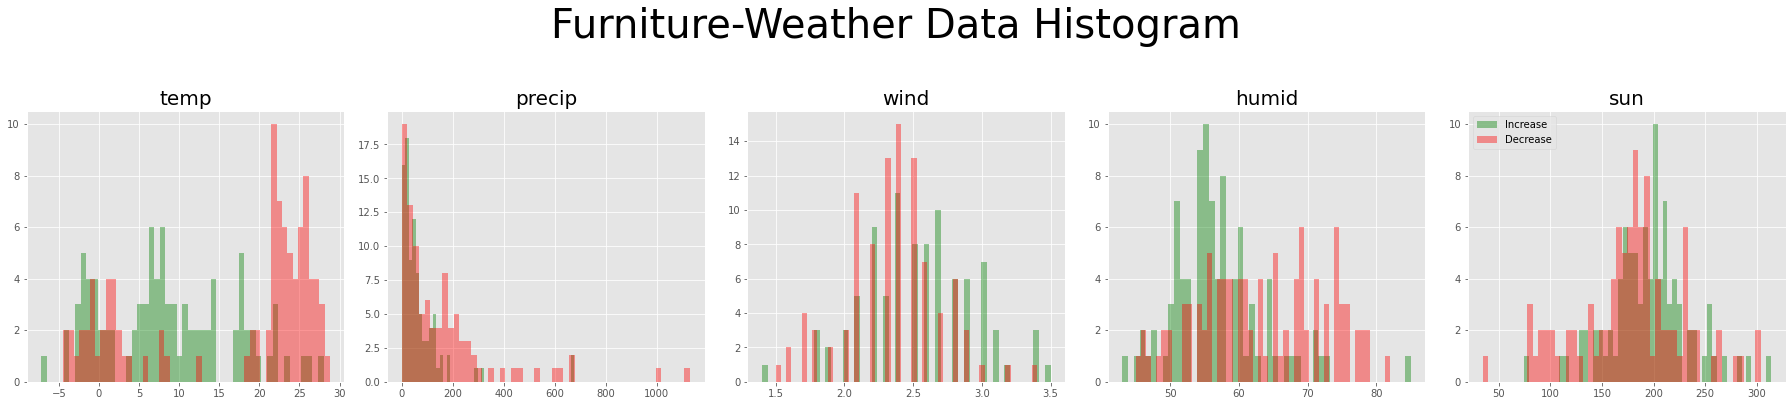

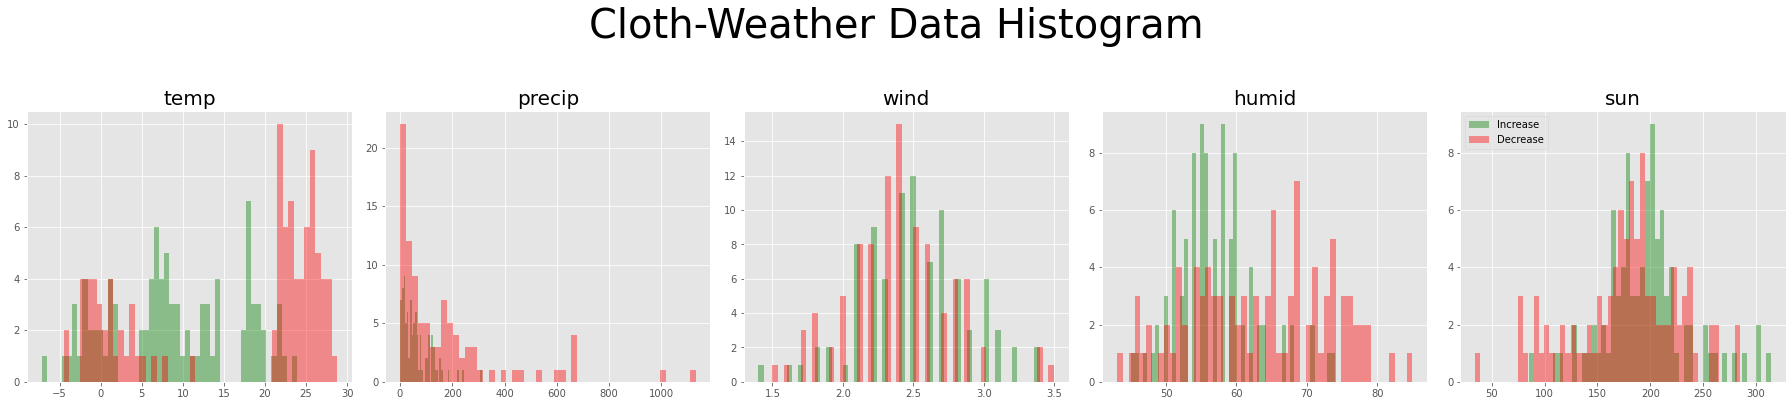

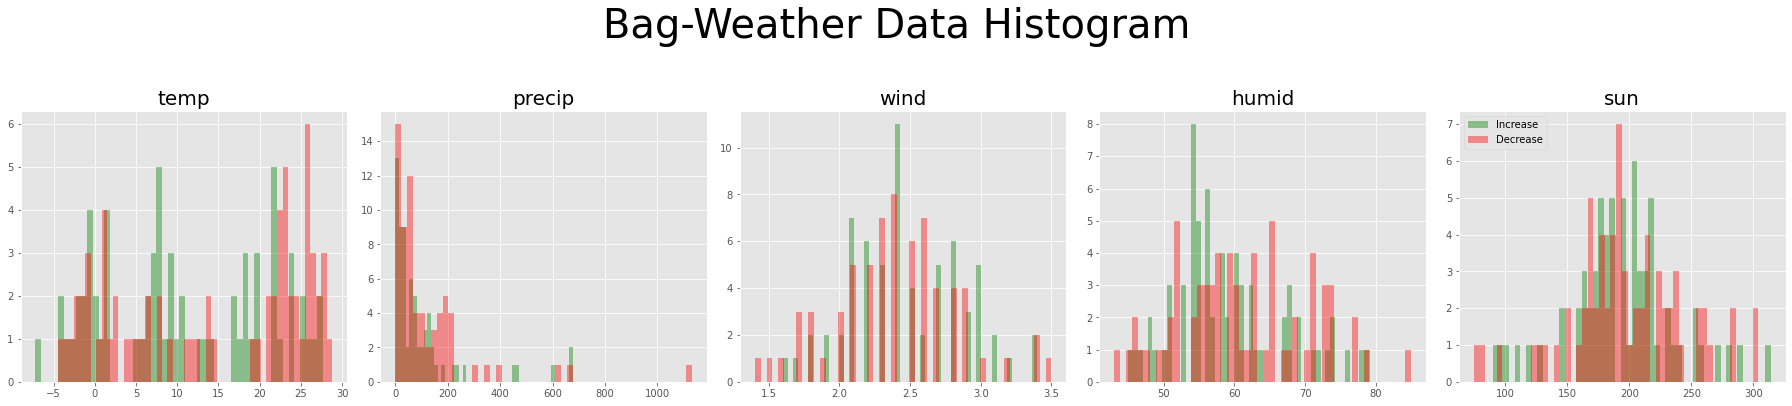

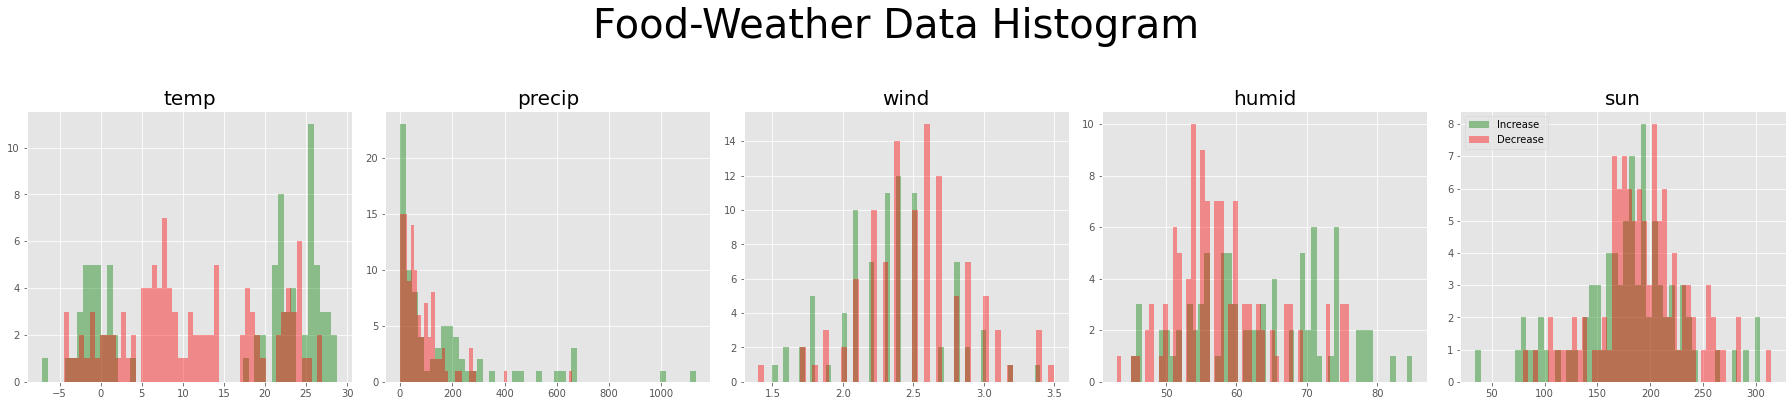

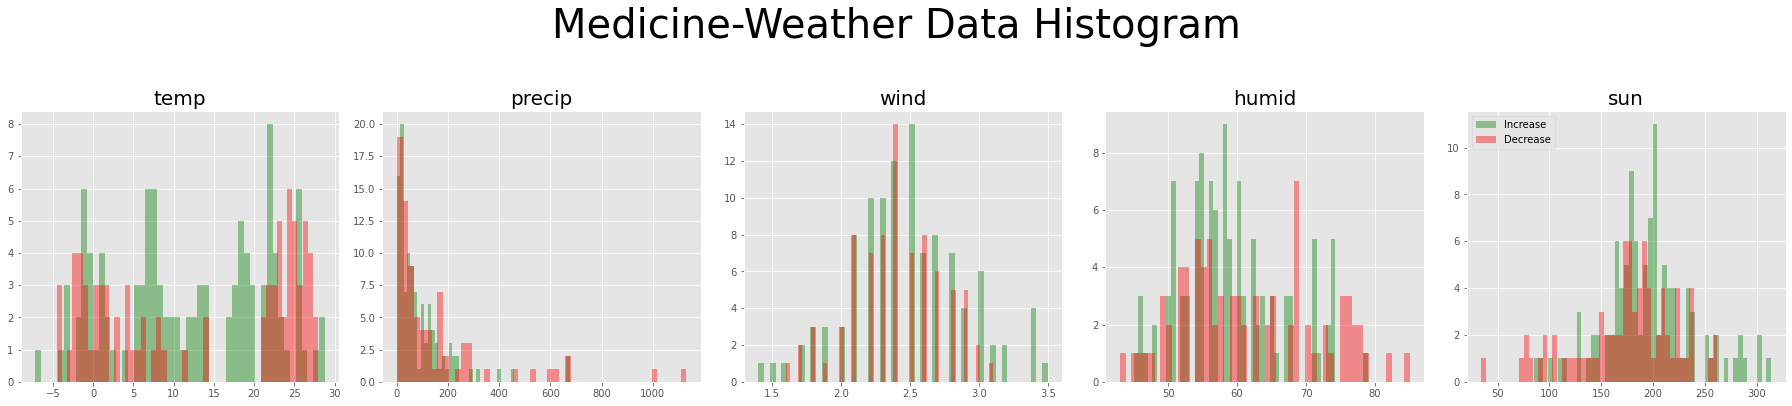

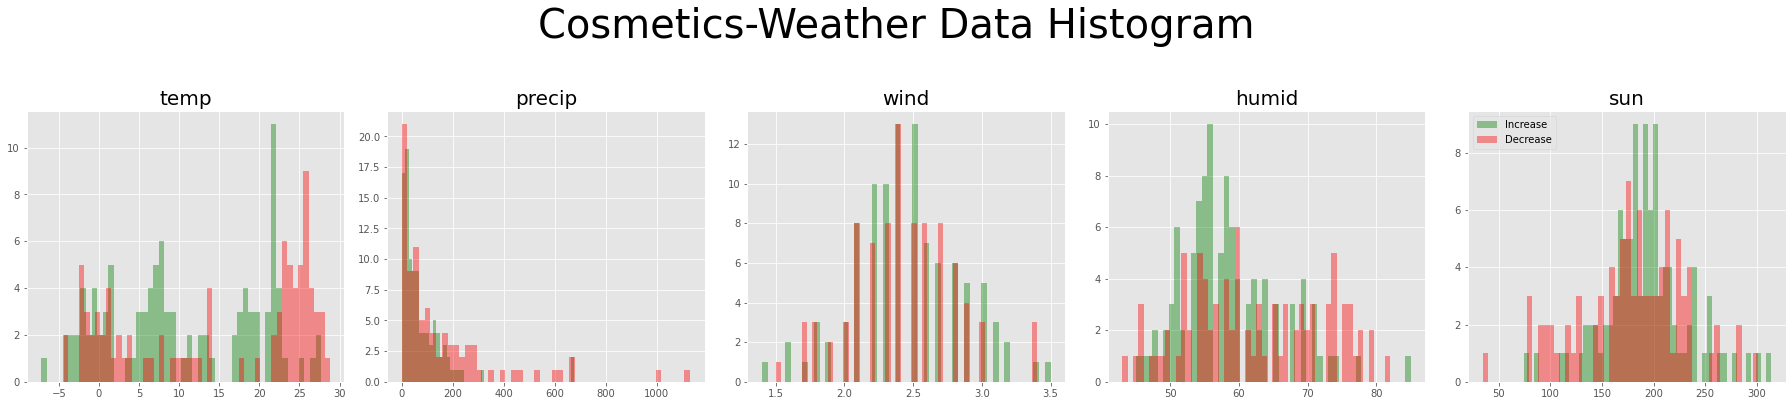

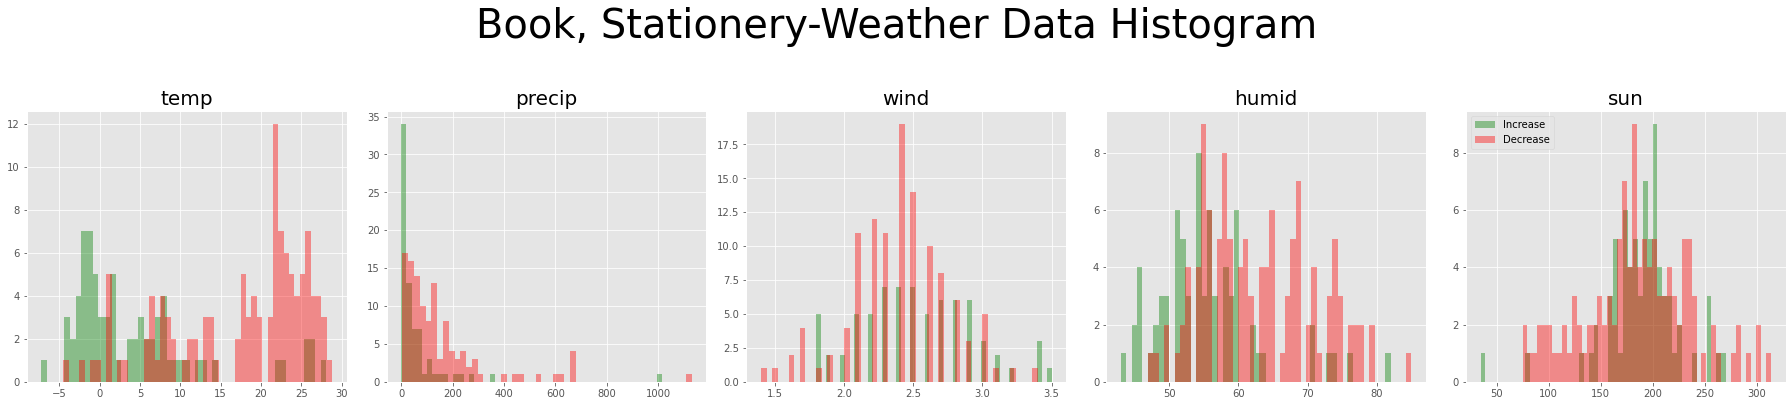

In [9]:
# 판매지수 증감여부에 따른 날씨 데이터 히스토그램
for i,p in enumerate(product_columns):       
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = tmp_increase.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{product_list[i]}-Weather Data Histogram", fontsize=40)
    
    j=0
    for col in tmp_increase.columns:
        j+=1
        plt.subplot(len_row,len_col,j)
        plt.title(col, fontsize=20)
        plt.hist(tmp_increase[col], color = 'green', alpha = 0.4, bins = 50, label='Increase')
        plt.hist(tmp_decrease[col], color = 'red', alpha = 0.4, bins = 50, label='Decrease')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend(loc='upper left')
    plt. show()

In [11]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 판매지수 증감여부에 따른 날씨 데이터 ANOVA
for i,p in product_columns:
    print(f'상품군 :{p}\n')
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = ['temp','precip', 'wind', 'humid', 'sun']
    
    for col in cols:
        print(f'변수 :{col}\n')
        model = ols(f'sales_increase ~ {col}', df_dict[p][['sales_increase']+[col]]).fit()
        display(anova_lm(model))
    print('------------------------------------\n')

상품군 :승용차

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.361927,1.361927,5.585594,0.018897
Residual,243.0,59.250318,0.243828,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.032431,0.032431,0.130087,0.718655
Residual,243.0,60.579814,0.249300,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.101027,0.101027,0.405701,0.524759
Residual,243.0,60.511218,0.249017,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.156451,0.156451,0.628849,0.428551
Residual,243.0,60.455794,0.248789,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.403275,0.403275,1.627595,0.203254
Residual,243.0,60.208970,0.247774,NaN,NaN


------------------------------------

상품군 :가전제품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,7.364020,7.364020,34.511733,1.892204e-08
Residual,188.0,40.114928,0.213377,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,5.077600,5.077600,22.513172,0.000004
Residual,188.0,42.401347,0.225539,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.957791,1.957791,8.085573,0.004956
Residual,188.0,45.521157,0.242134,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,12.093597,12.093597,64.252469,1.130091e-13
Residual,188.0,35.385351,0.188220,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,2.402891,2.402891,10.021806,0.001805
Residual,188.0,45.076057,0.239766,NaN,NaN


------------------------------------

상품군 :가구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,6.326409,6.326409,28.919869,2.222095e-07
Residual,188.0,41.126222,0.218757,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,3.243554,3.243554,13.79328,0.000269
Residual,188.0,44.209078,0.235155,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,3.114137,3.114137,13.204275,0.00036
Residual,188.0,44.338495,0.235843,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,7.019210,7.019210,32.636654,4.286530e-08
Residual,188.0,40.433421,0.215071,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,1.513656,1.513656,6.194464,0.013684
Residual,188.0,45.938976,0.244356,NaN,NaN


------------------------------------

상품군 :의복

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,5.378679,5.378679,24.018652,0.000002
Residual,188.0,42.100268,0.223938,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,4.753109,4.753109,20.91438,0.000009
Residual,188.0,42.725839,0.227265,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.897637,0.897637,3.62282,0.05852
Residual,188.0,46.581311,0.247773,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,6.212683,6.212683,28.303615,2.928772e-07
Residual,188.0,41.266264,0.219501,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,1.950683,1.950683,8.054961,0.005036
Residual,188.0,45.528264,0.242172,NaN,NaN


------------------------------------

상품군 :가방

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.026772,1.026772,4.173439,0.043038
Residual,133.0,32.721376,0.246025,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.140259,0.140259,0.555061,0.457571
Residual,133.0,33.607889,0.252691,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.295246,0.295246,1.173821,0.280578
Residual,133.0,33.452902,0.251526,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.384282,0.384282,1.531881,0.218011
Residual,133.0,33.363866,0.250856,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.053326,0.053326,0.210488,0.647134
Residual,133.0,33.694822,0.253345,NaN,NaN


------------------------------------

상품군 :음식료품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.396537,1.396537,5.806807,0.016928
Residual,188.0,45.213989,0.240500,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,2.910942,2.910942,12.523166,0.000506
Residual,188.0,43.699584,0.232445,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,2.749916,2.749916,11.786982,0.000734
Residual,188.0,43.860610,0.233301,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,3.614327,3.614327,15.80357,0.0001
Residual,188.0,42.996199,0.228703,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.890423,0.890423,3.661397,0.057206
Residual,188.0,45.720104,0.243192,NaN,NaN


------------------------------------

상품군 :의약품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,0.149040,0.14904,0.604921,0.437684
Residual,188.0,46.319381,0.24638,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,1.248657,1.248657,5.191258,0.023825
Residual,188.0,45.219764,0.240531,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.355599,0.355599,1.449763,0.23008
Residual,188.0,46.112822,0.245281,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,1.123074,1.123074,4.656219,0.03221
Residual,188.0,45.345347,0.241199,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,2.486348,2.486348,10.627816,0.001322
Residual,188.0,43.982073,0.233947,NaN,NaN


------------------------------------

상품군 :화장품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,2.053288,2.053288,8.542336,0.003896
Residual,188.0,45.188818,0.240366,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,2.642993,2.642993,11.141091,0.001018
Residual,188.0,44.599112,0.237229,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.056161,0.056161,0.223759,0.63674
Residual,188.0,47.185944,0.250989,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,2.295029,2.295029,9.59941,0.002245
Residual,188.0,44.947076,0.239080,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.963400,0.963400,3.913663,0.049356
Residual,188.0,46.278705,0.246163,NaN,NaN


------------------------------------

상품군 :서적, 문구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,16.909635,16.909635,113.362046,5.121479e-21
Residual,188.0,28.042996,0.149165,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,3.158155,3.158155,14.20602,0.000219
Residual,188.0,41.794476,0.222311,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.260672,1.260672,5.424484,0.020919
Residual,188.0,43.691960,0.232404,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,8.168612,8.168612,41.749079,8.666016e-10
Residual,188.0,36.784020,0.195660,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.130710,0.130710,0.548249,0.459958
Residual,188.0,44.821921,0.238414,NaN,NaN


------------------------------------



In [12]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx
        
# 함수 사용해서 이상치 값 삭제
for i,p in enumerate(product_columns):
    for c in list(df_dict[p].iloc[:,1:-2].columns):
        outlier_idx = get_outlier(df=df_dict[p].iloc[:,1:-2].apply(pd.to_numeric), column = c, weight=1.5)
        df_dict[p].drop(outlier_idx, axis=0, inplace=True)
           
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')    

상품군 승용차의 데이터 크기 : (215, 8)
상품군 가전제품의 데이터 크기 : (161, 8)
상품군 가구의 데이터 크기 : (161, 8)
상품군 의복의 데이터 크기 : (161, 8)
상품군 가방의 데이터 크기 : (116, 8)
상품군 음식료품의 데이터 크기 : (161, 8)
상품군 의약품의 데이터 크기 : (161, 8)
상품군 화장품의 데이터 크기 : (161, 8)
상품군 서적, 문구의 데이터 크기 : (161, 8)


- **HeatMap 분석**

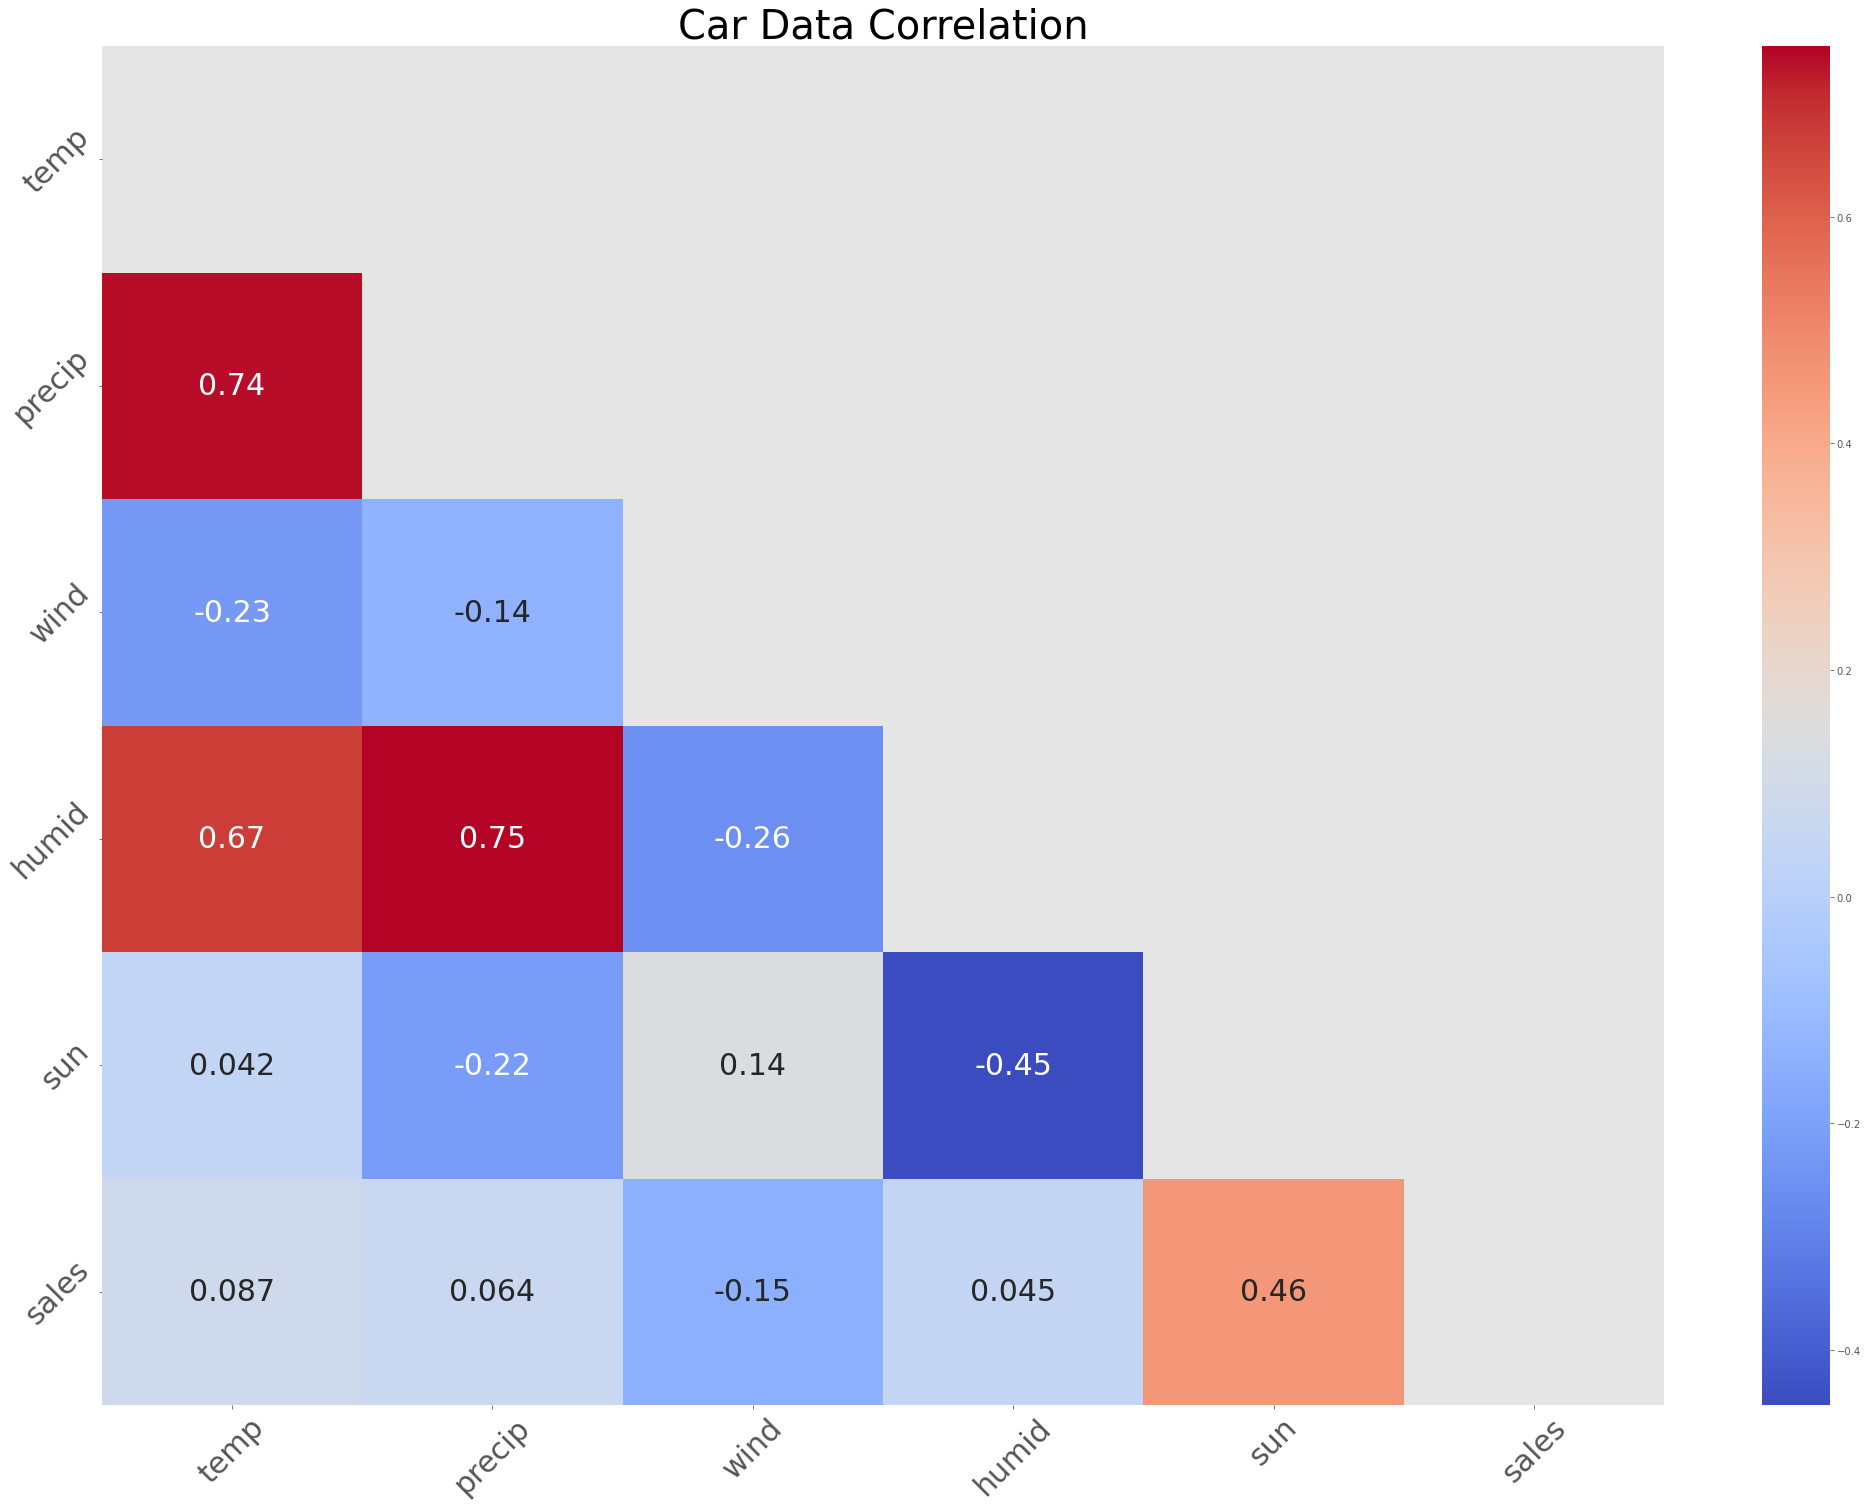

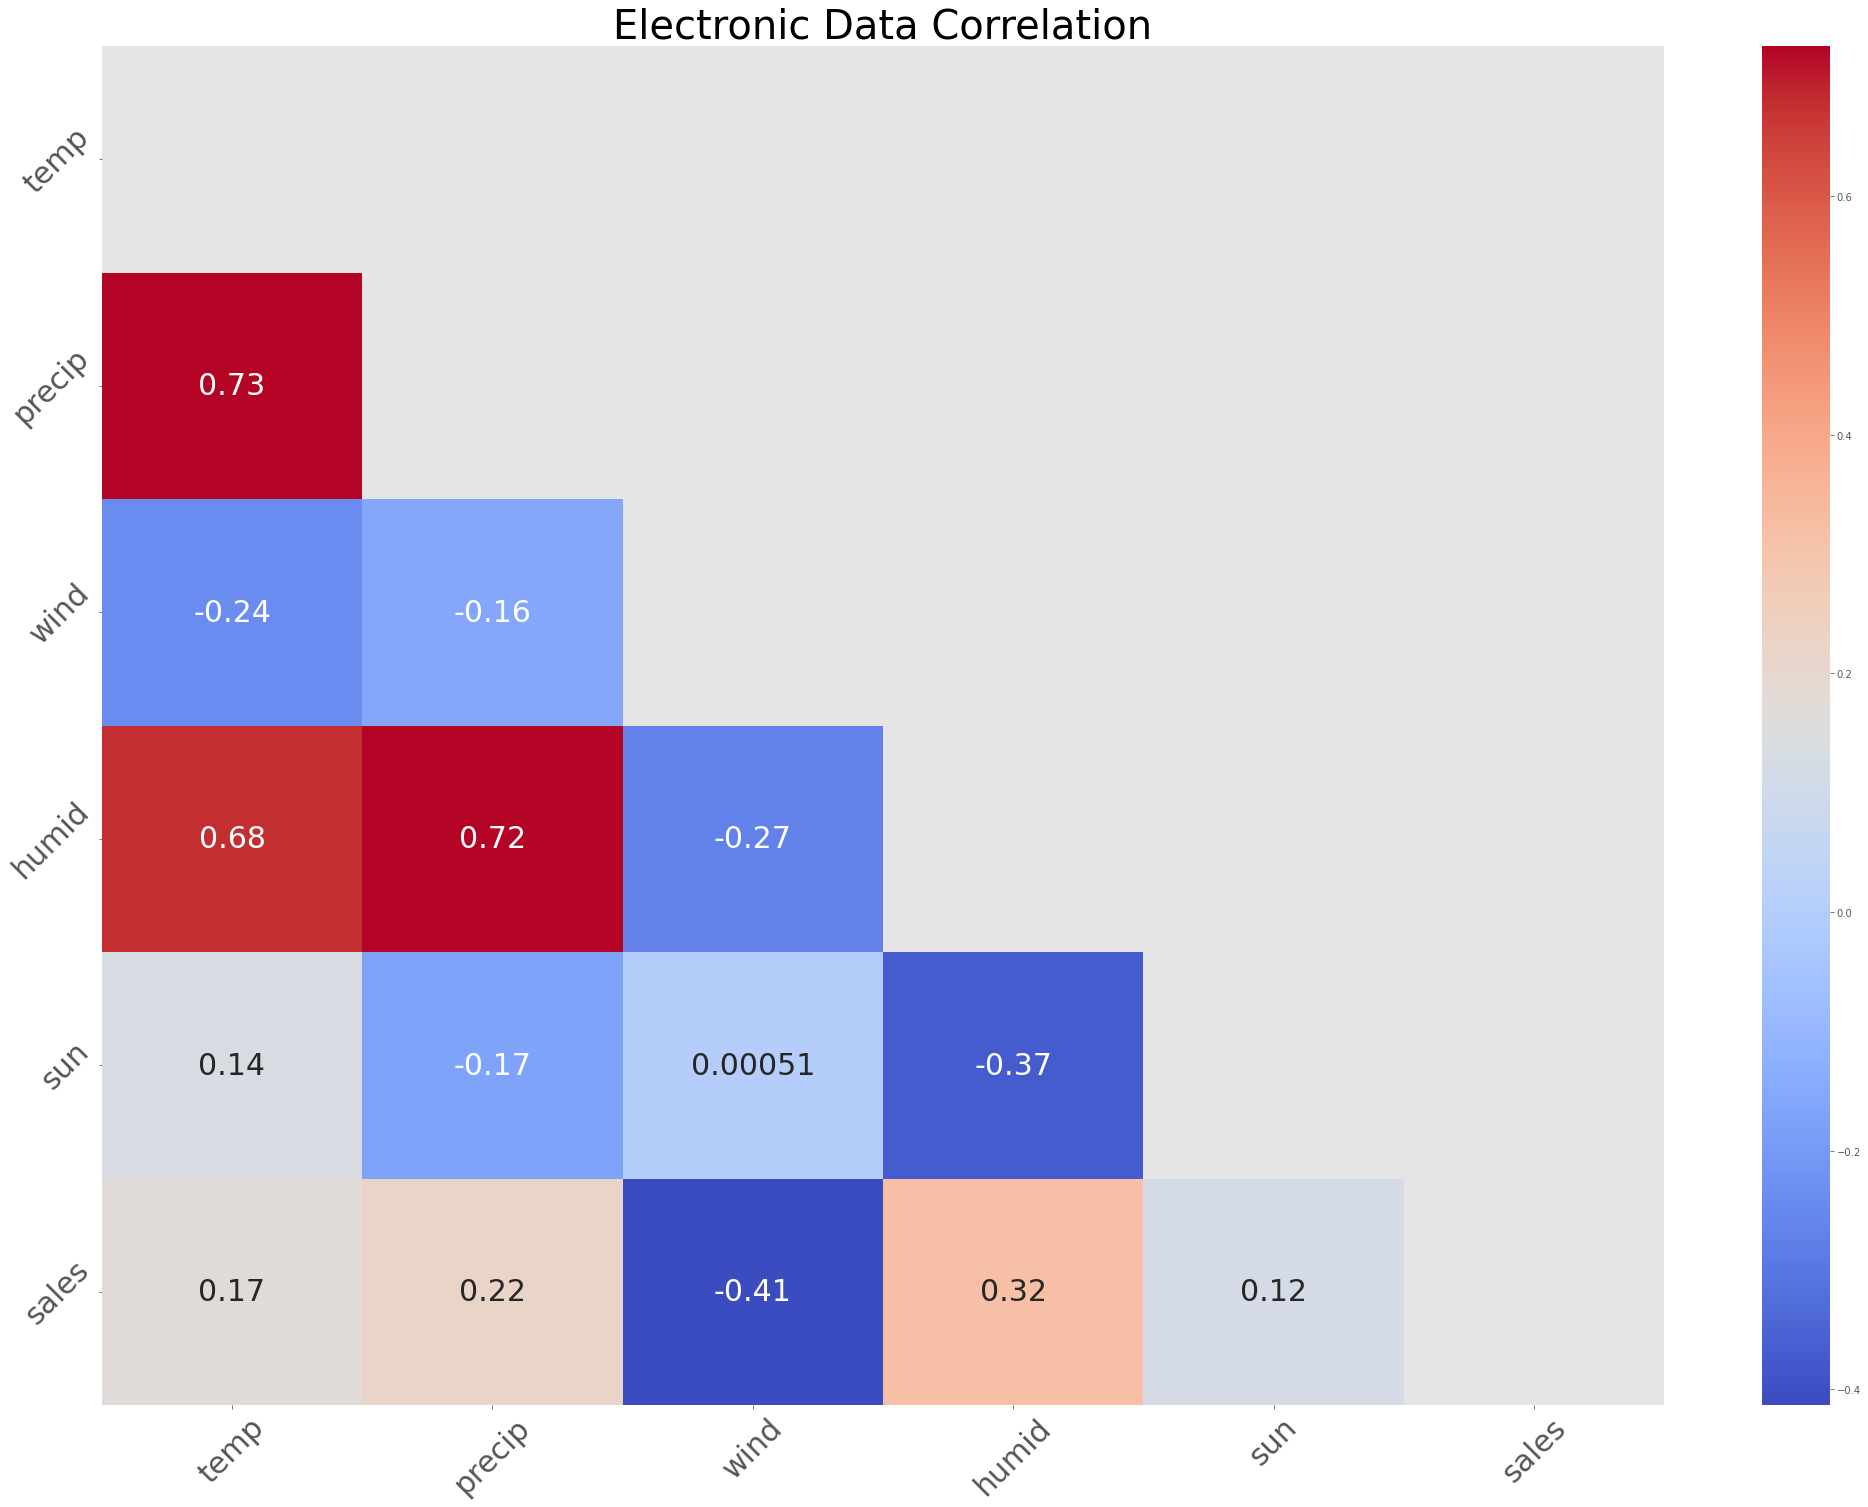

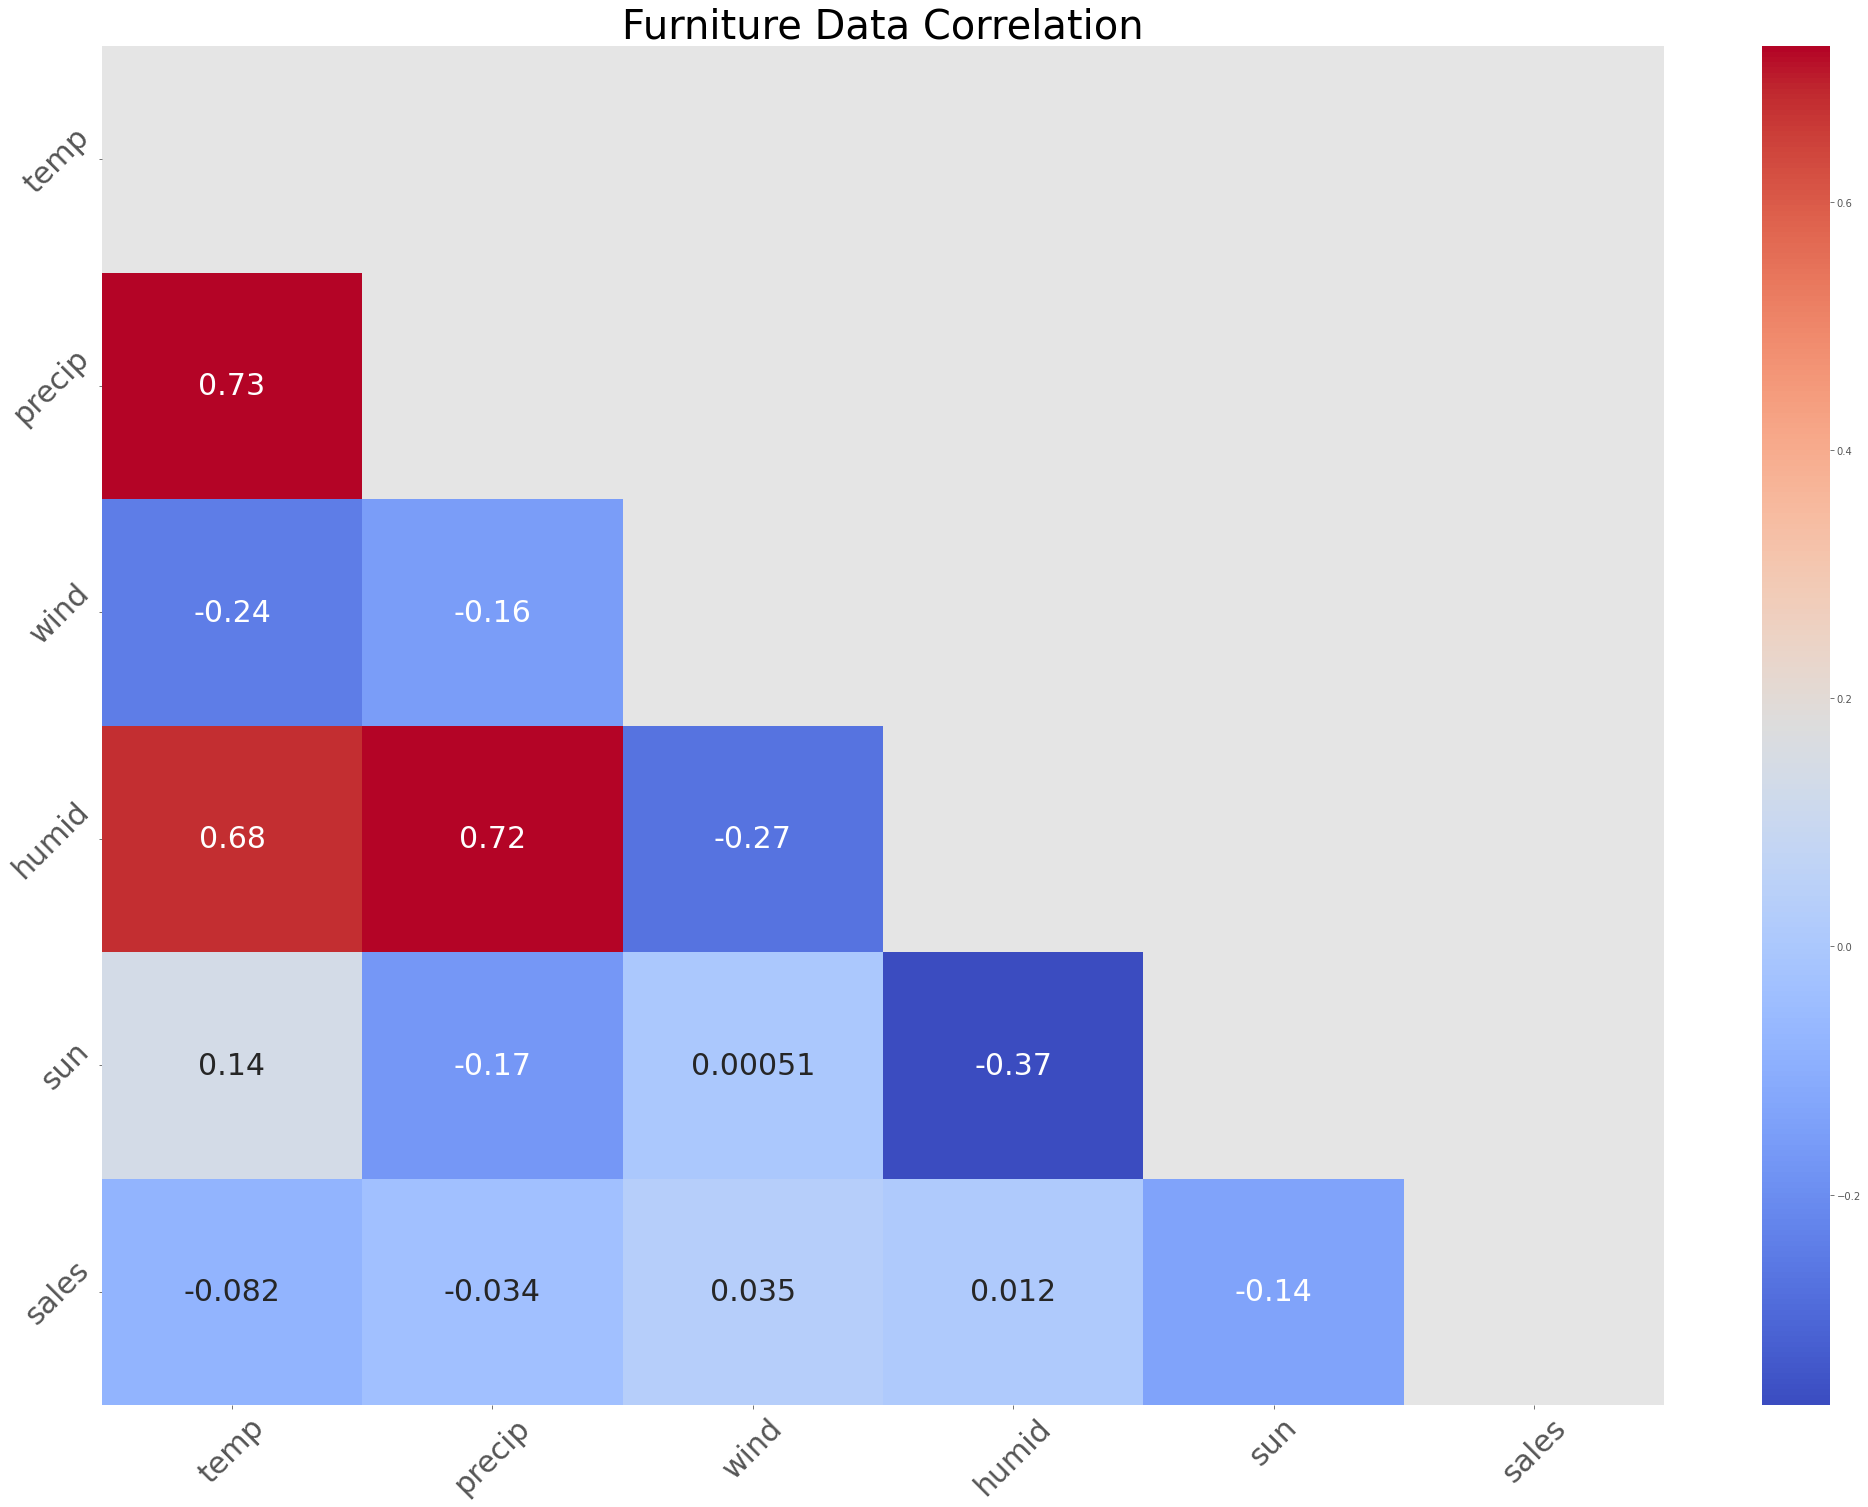

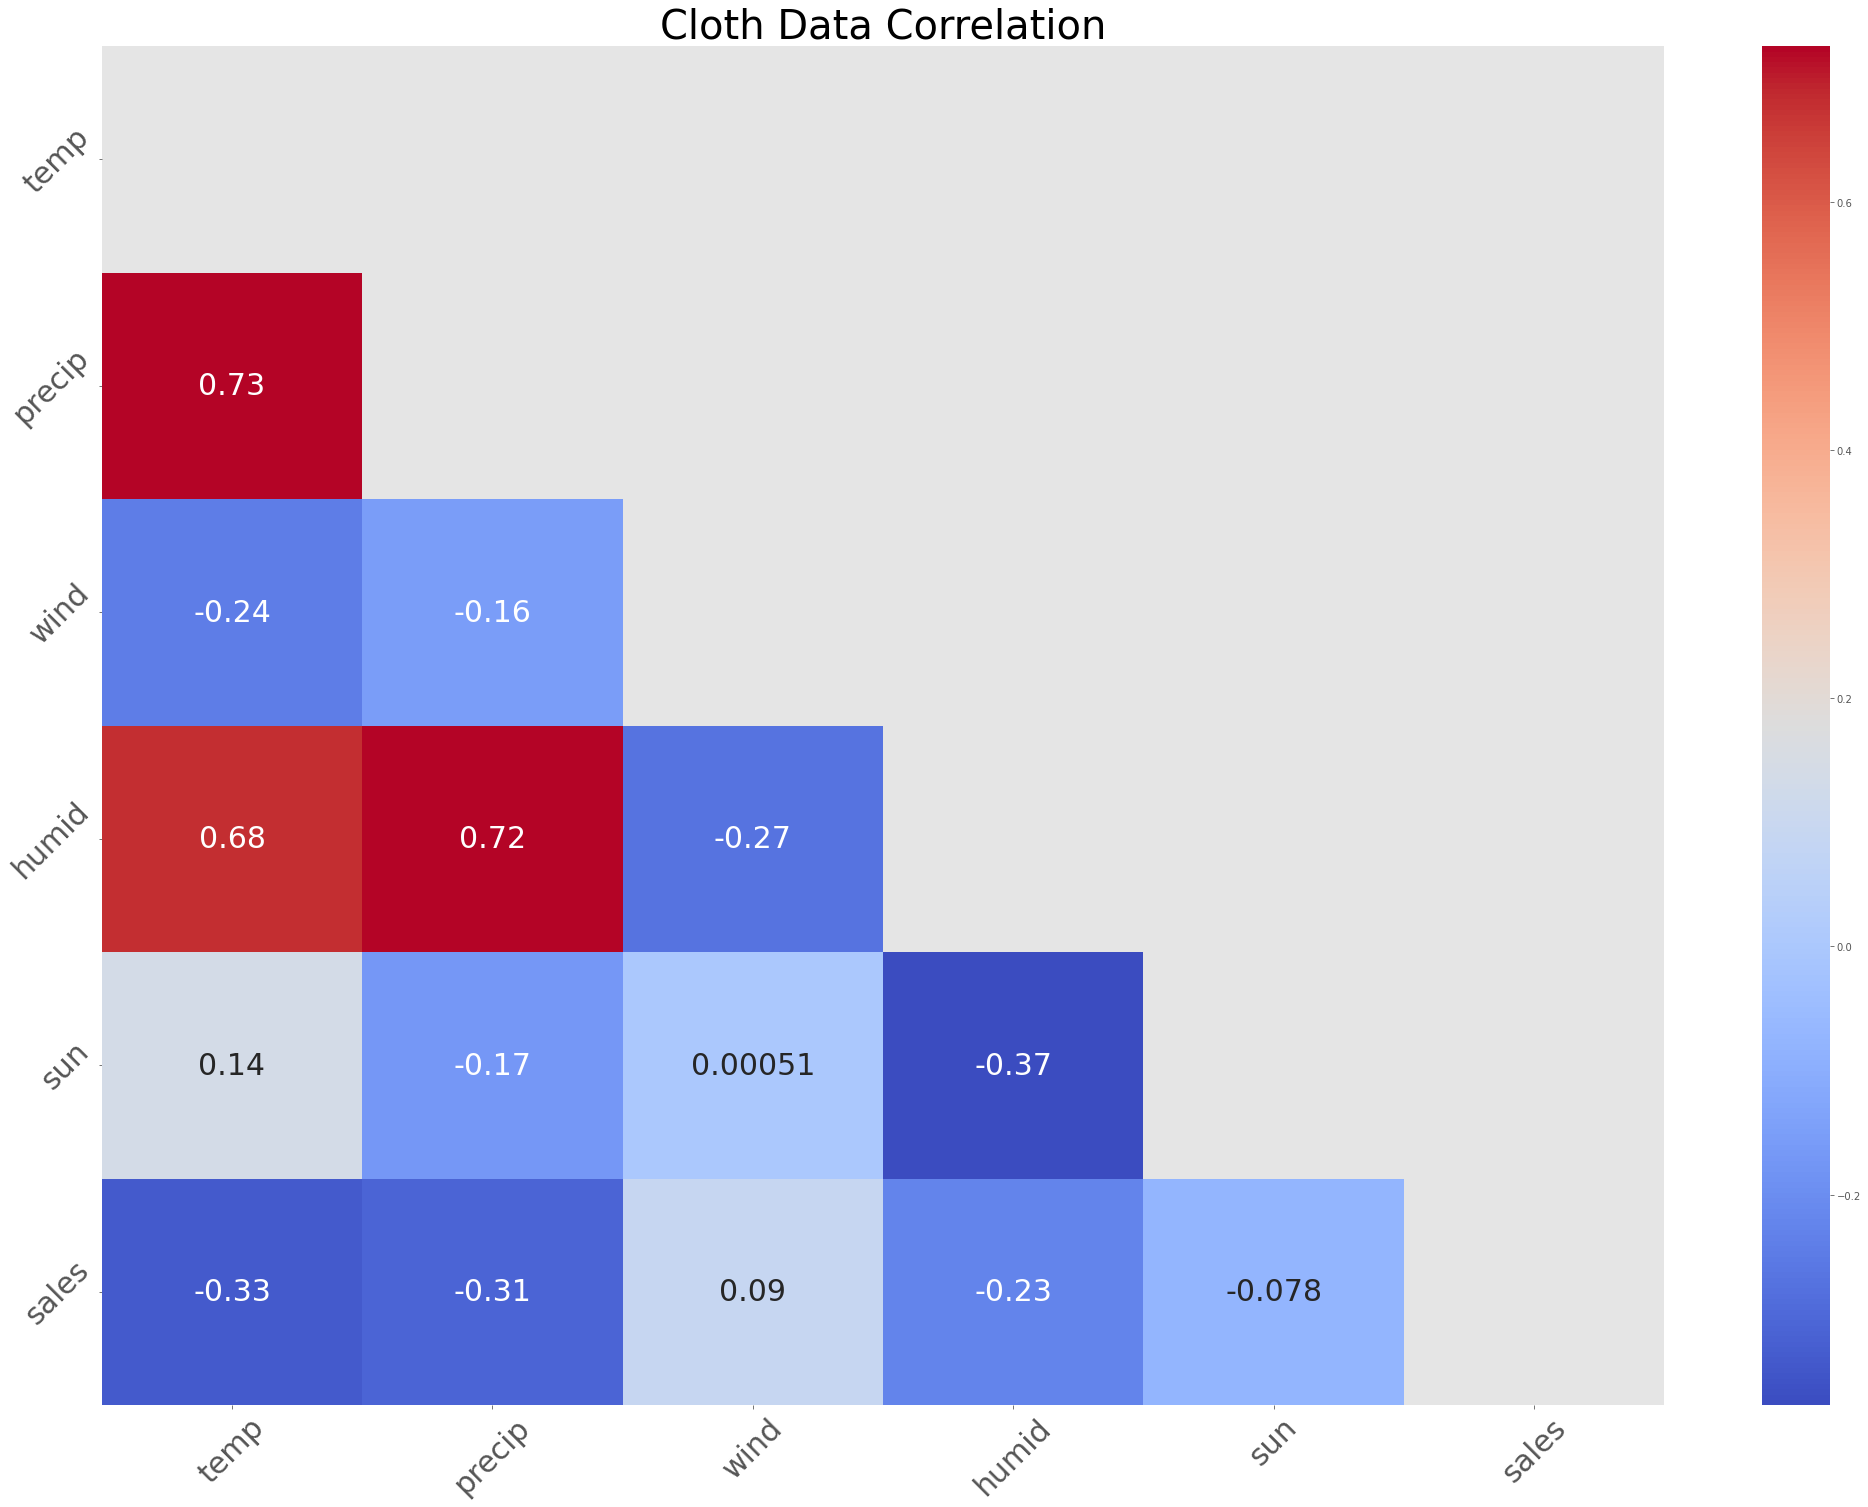

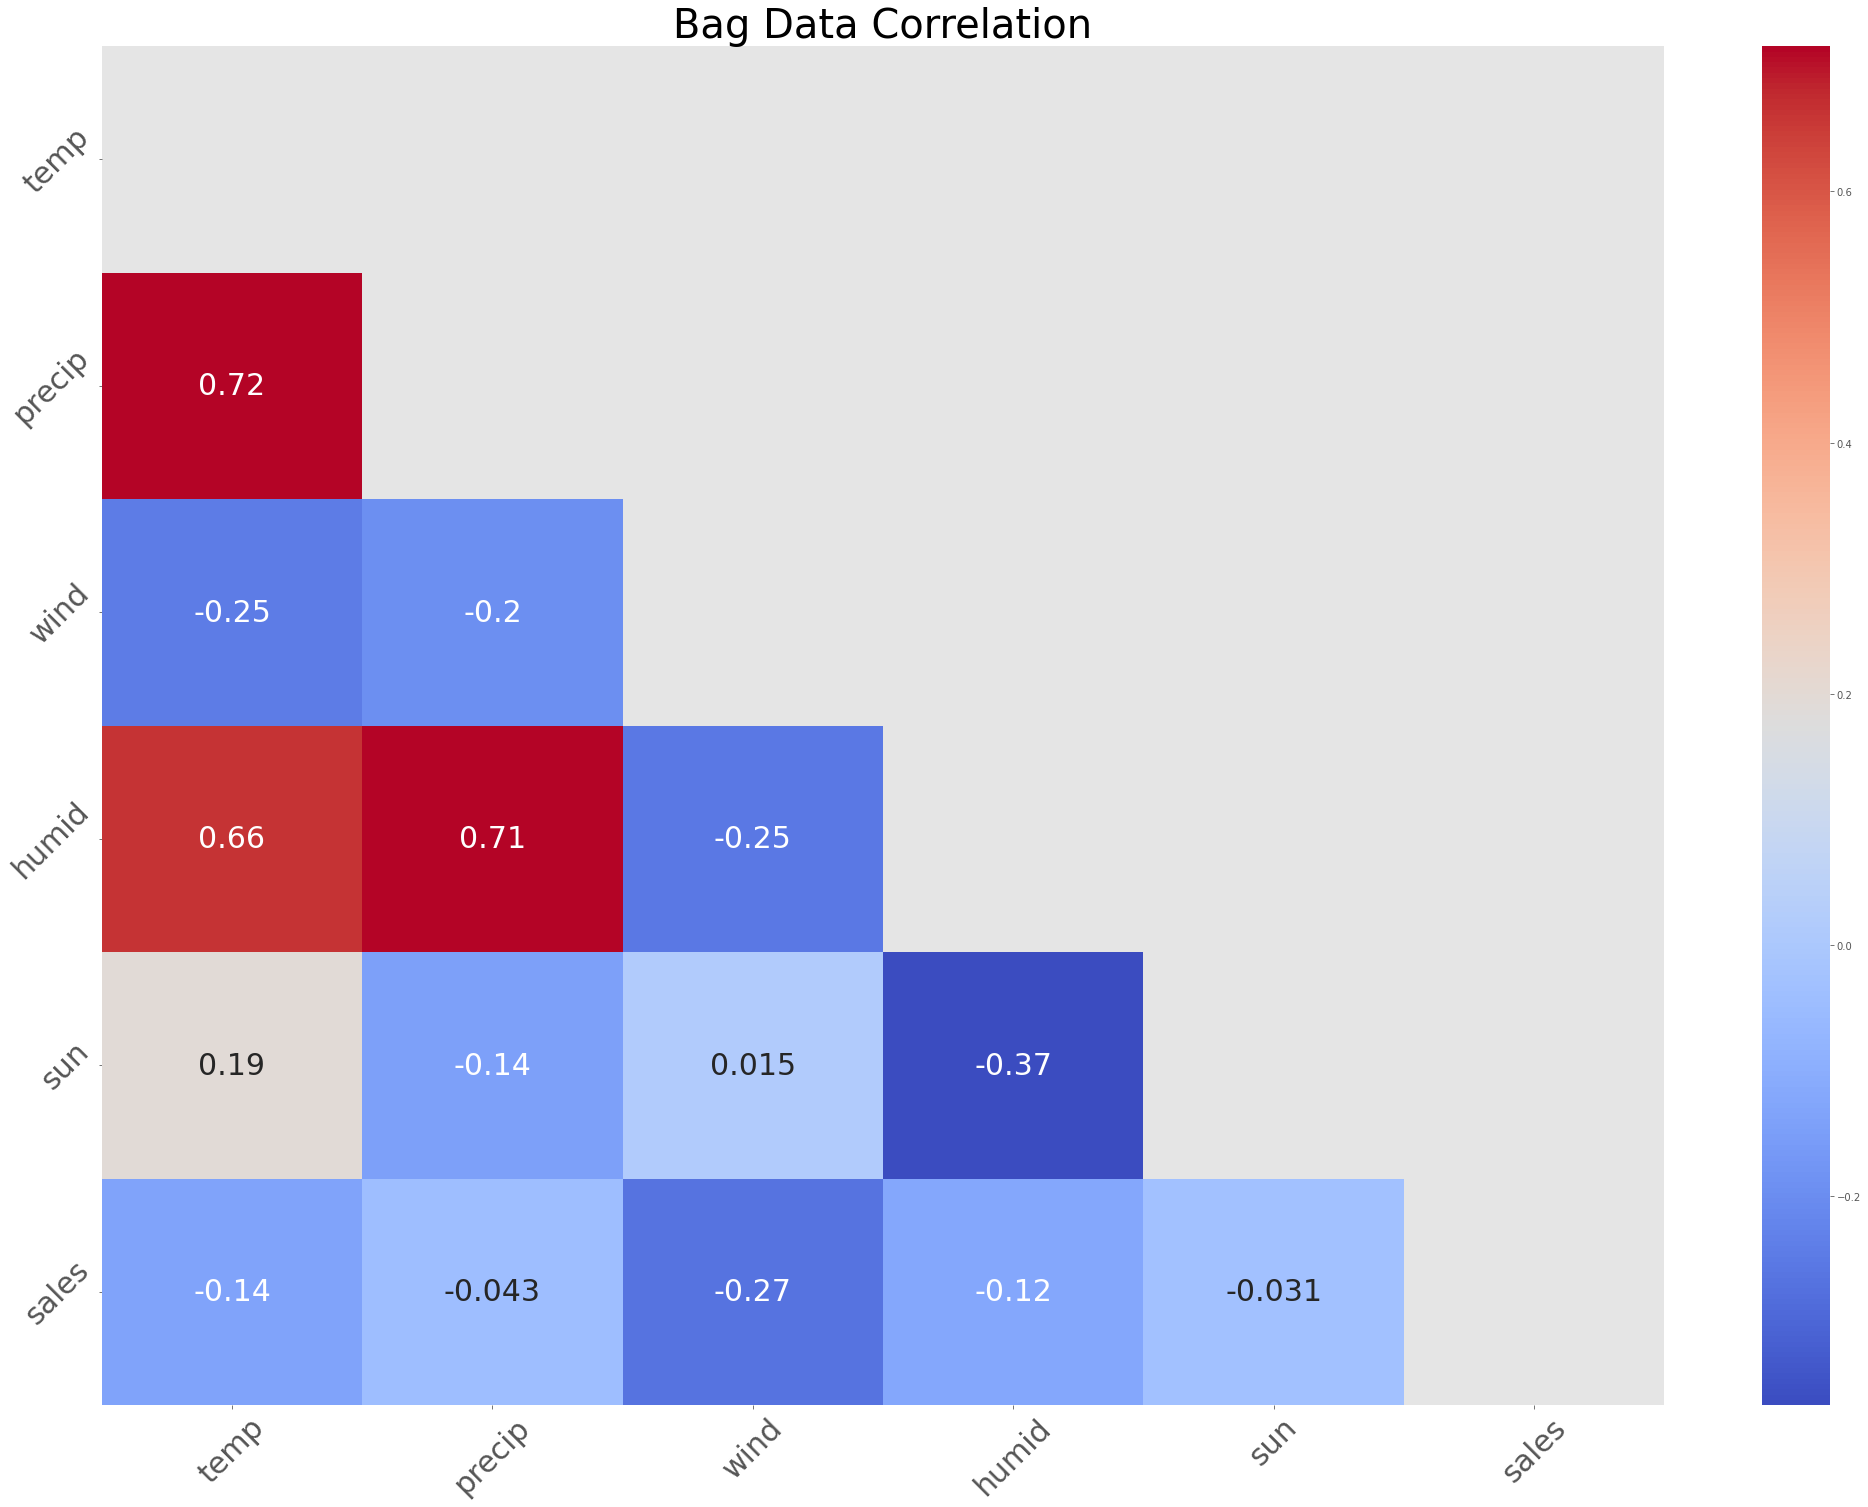

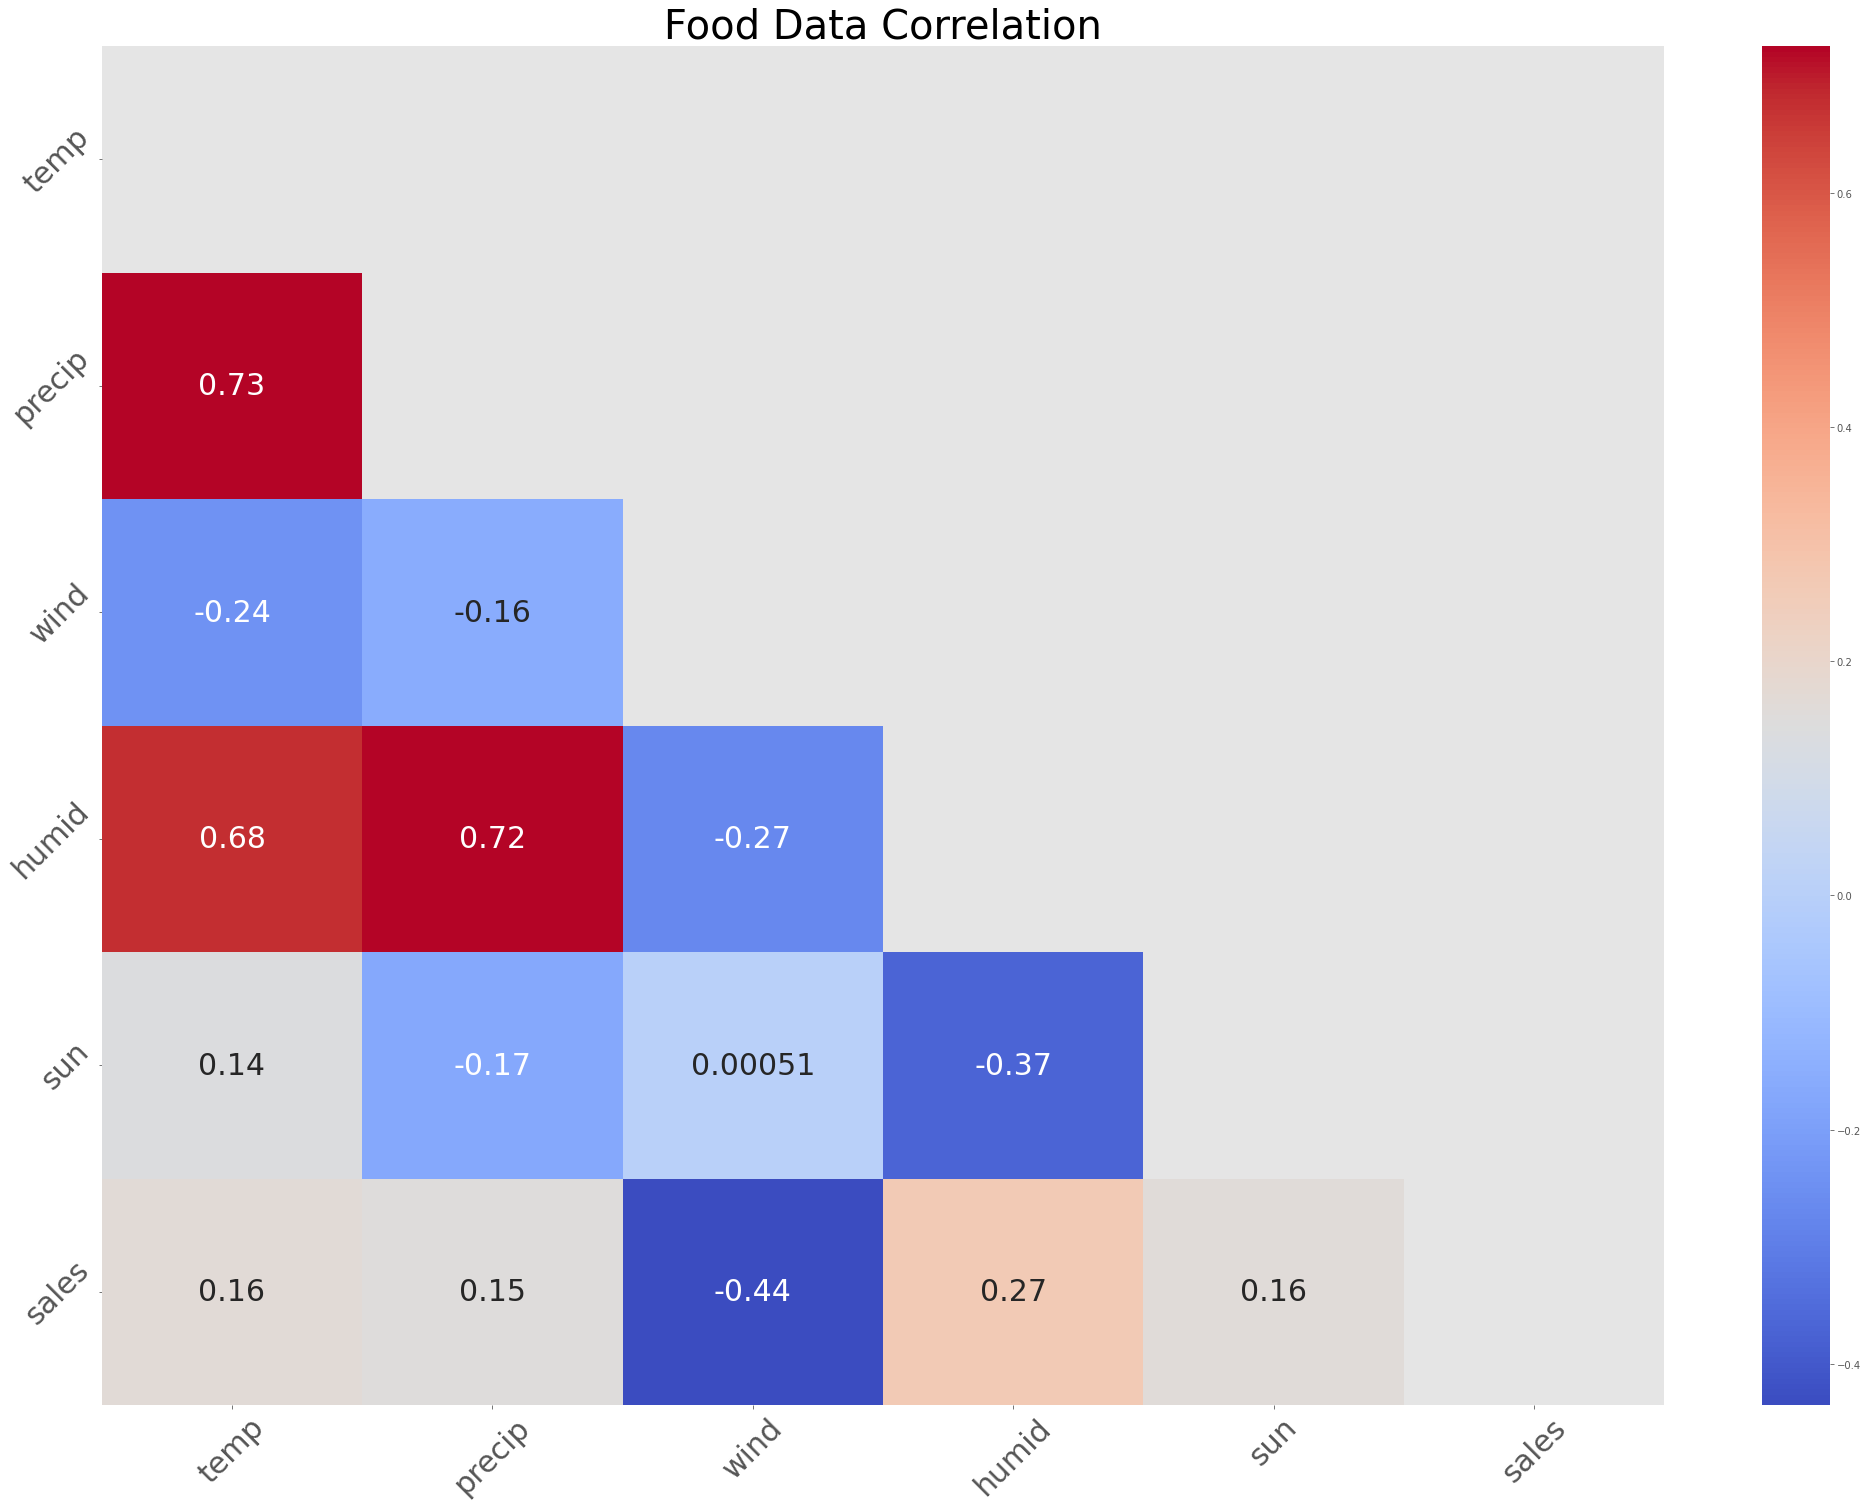

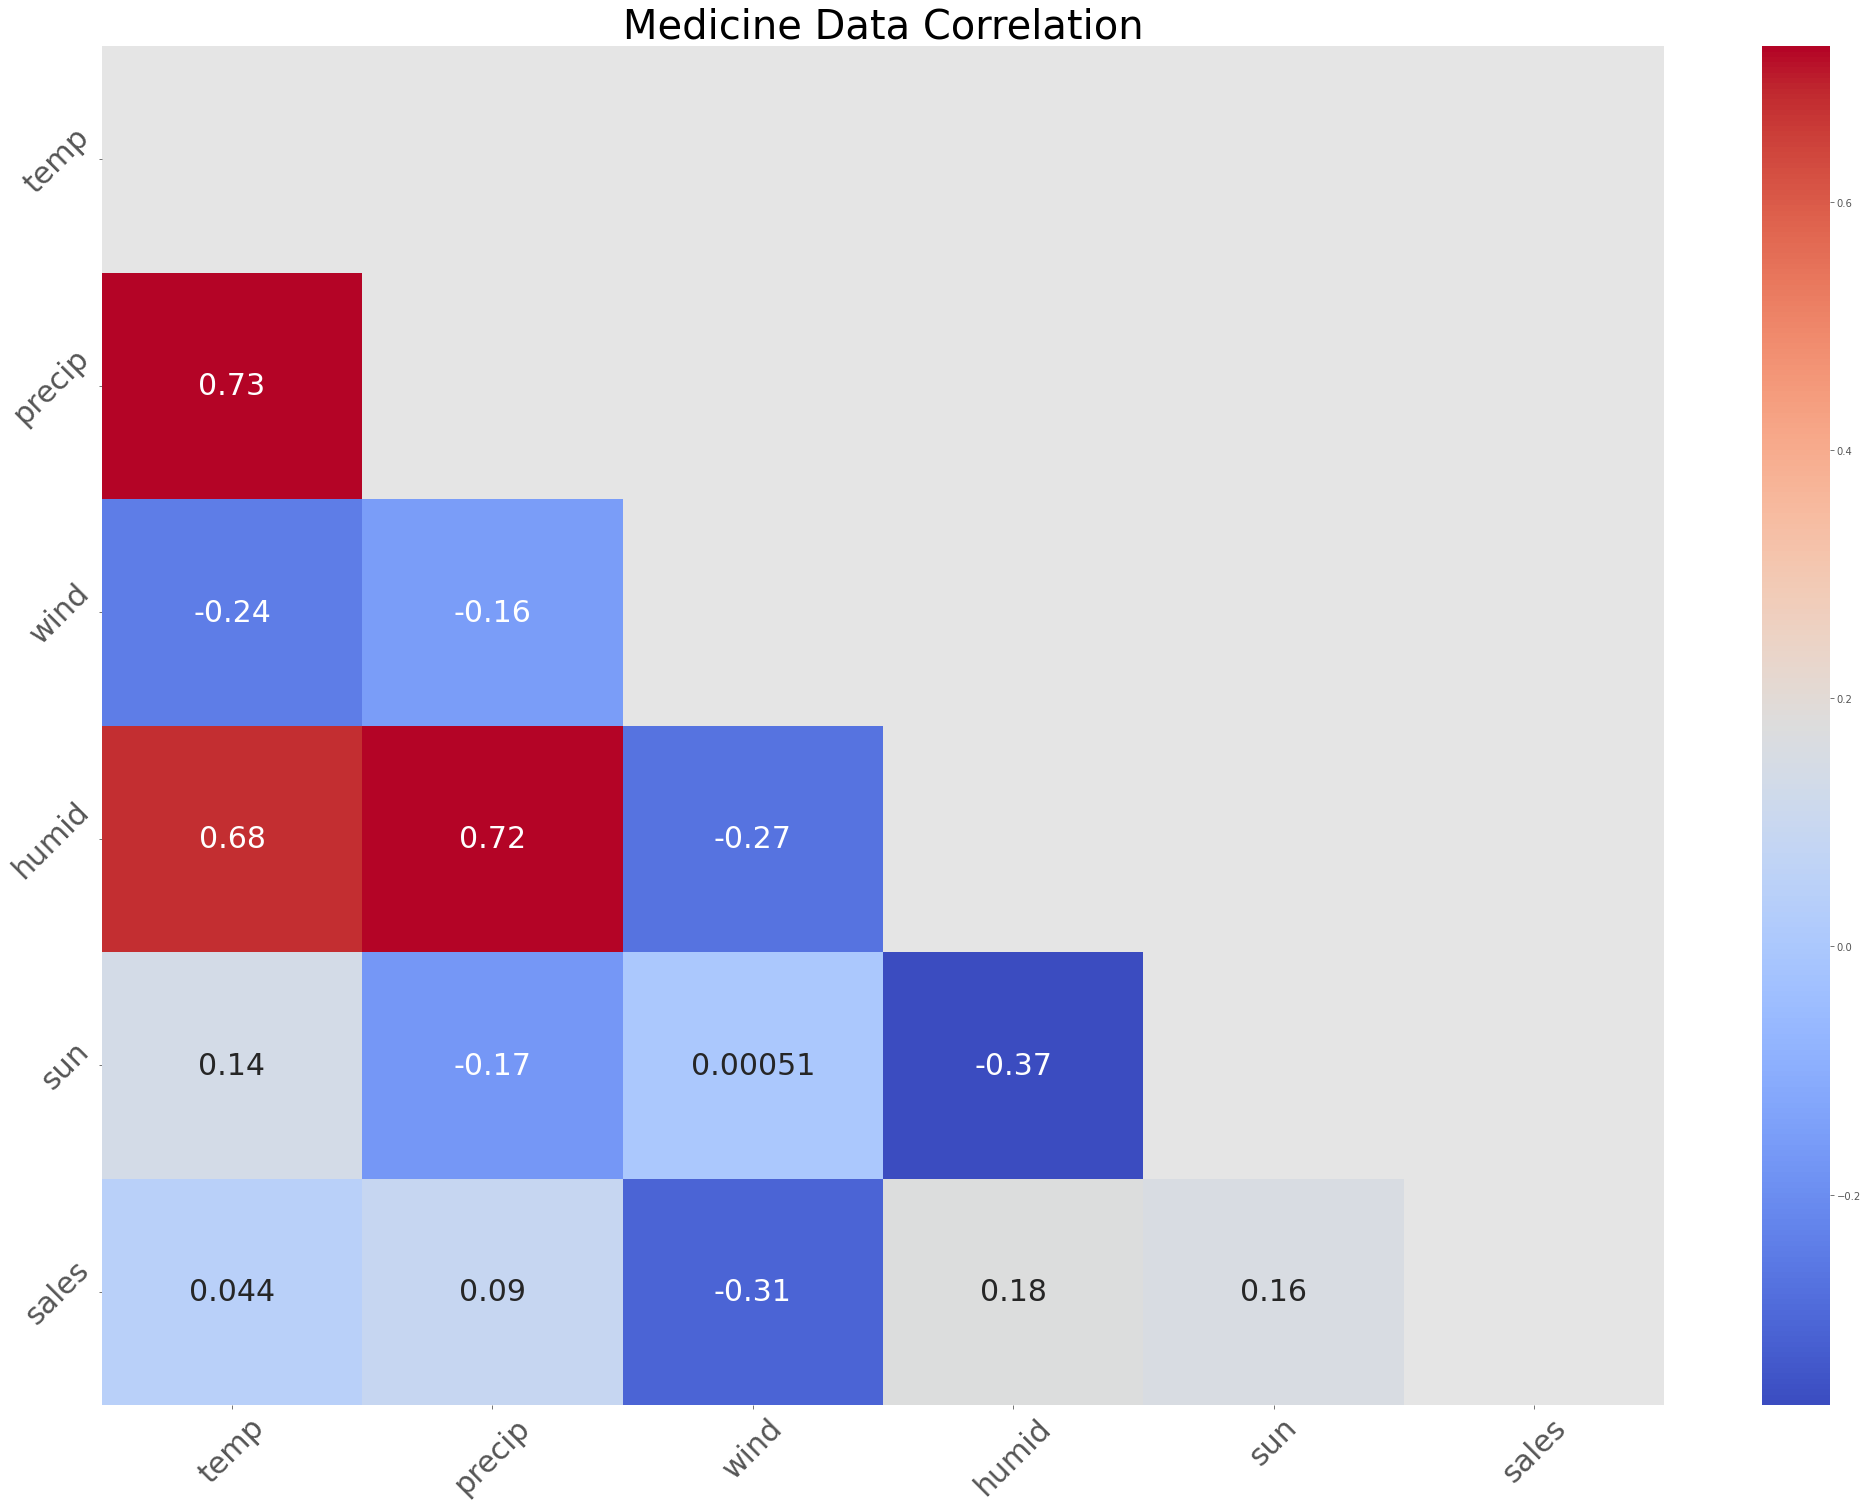

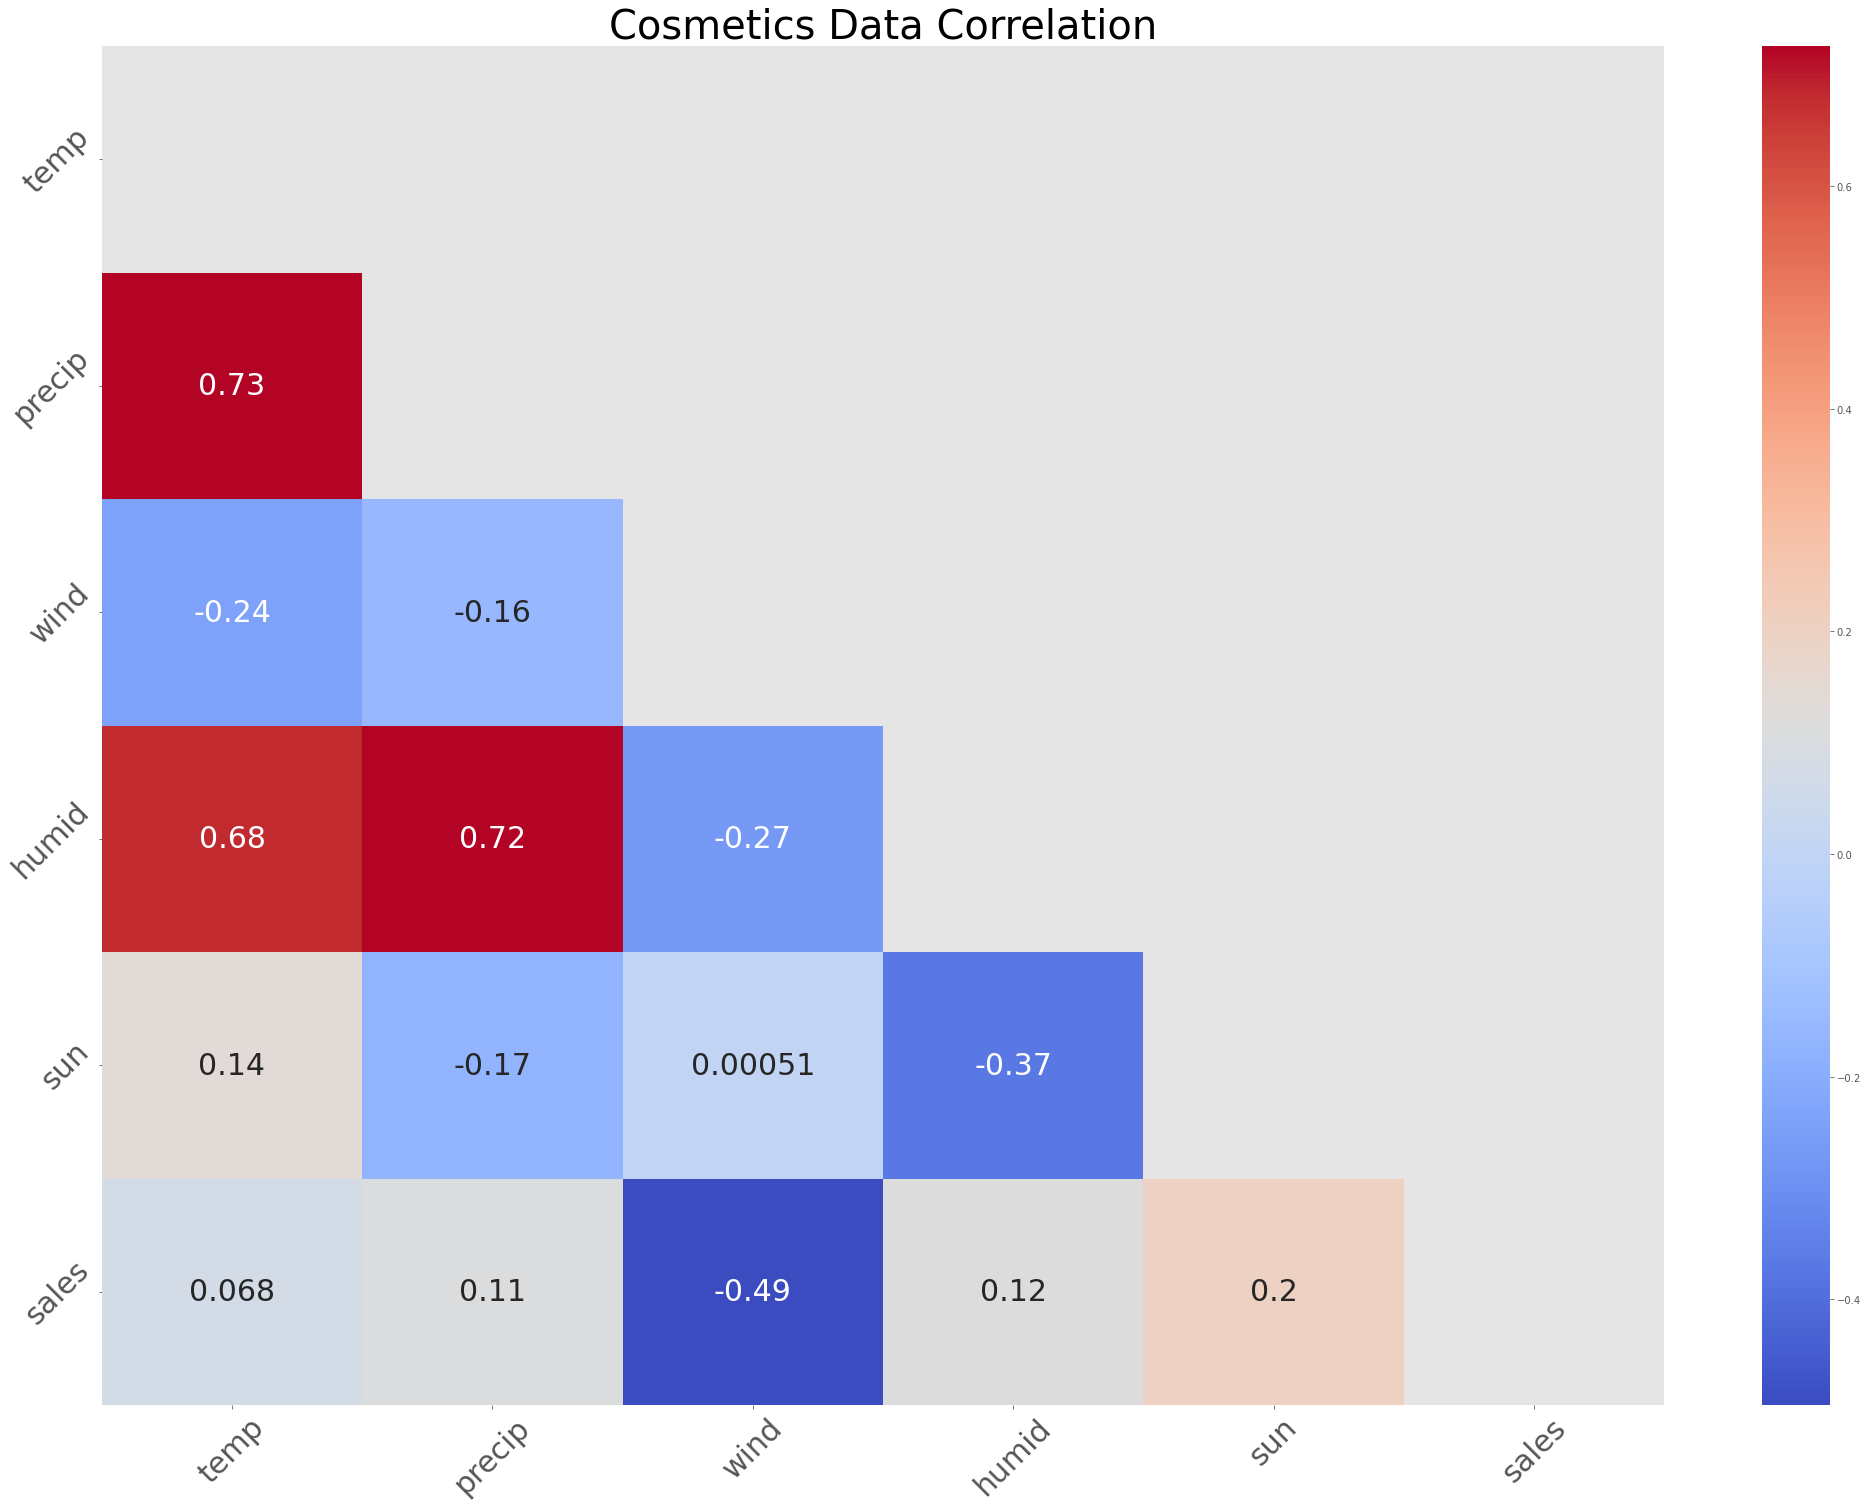

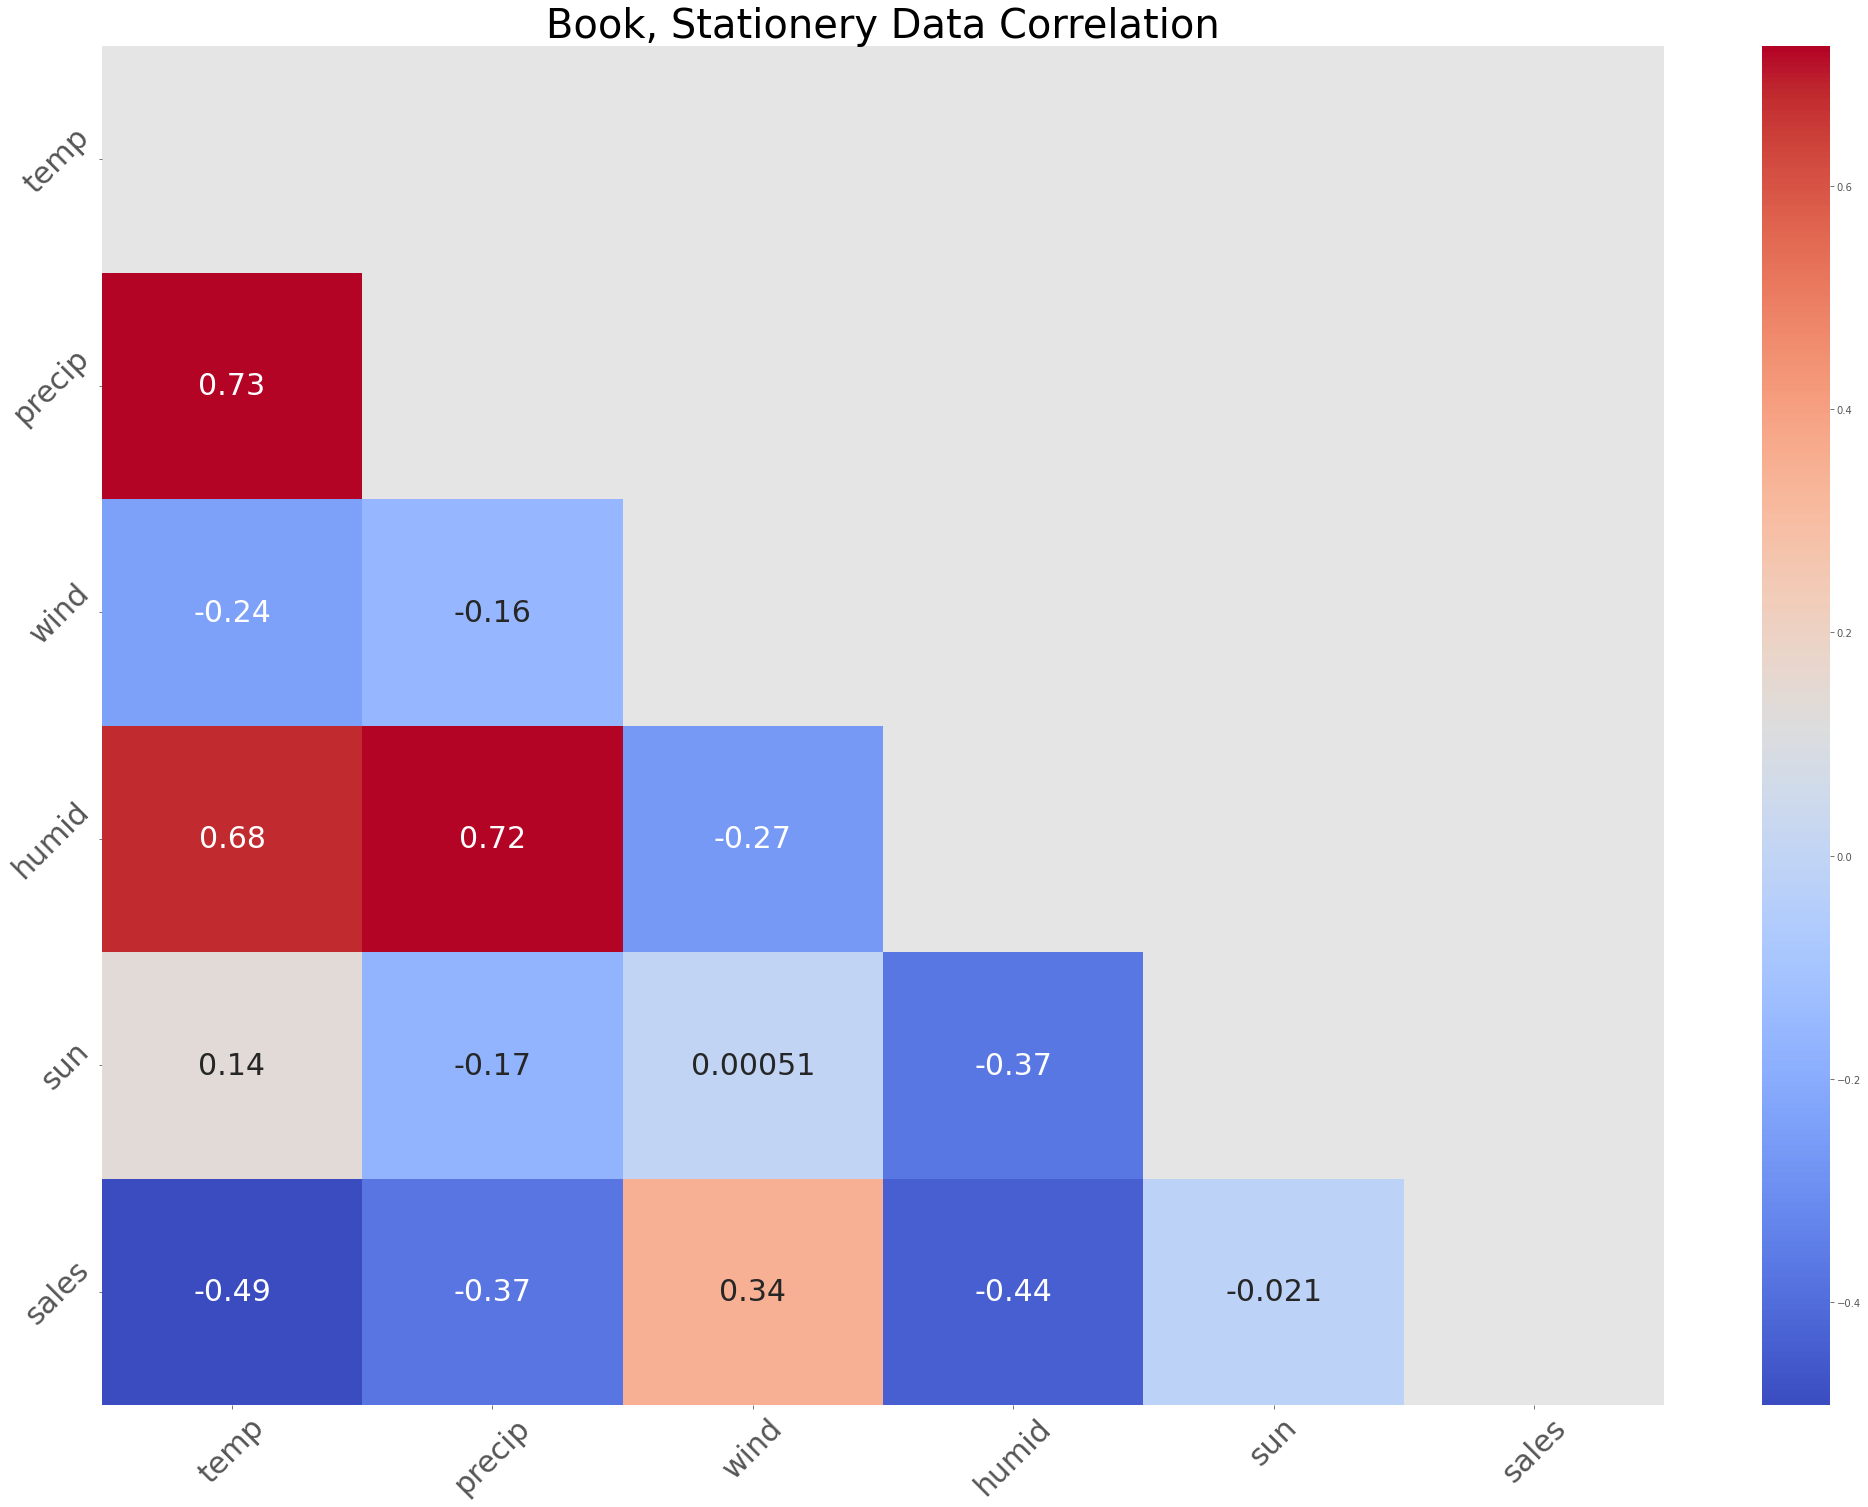

In [13]:
def plot_heatmap(df,title):
    plt.figure(figsize=(35,25))
    heat_table = df.corr(method="pearson")
    mask = np.zeros_like(heat_table)
    mask[np.triu_indices_from(mask)] = True
    heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={"fontsize":30}, mask = mask, cmap='coolwarm')
    heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=30, rotation=45)
    heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=30, rotation=45)
    plt.title(f'{title} Data Correlation', fontsize=40)
    plt.show()

# 각 데이터에 따른 히트맵 분석 (마지막 증감여부 제외)
for i,p in enumerate(product_columns):
    plot_heatmap(df_dict[p].iloc[:,:-1], product_list[i])

# 3. Data Preprocessing
## 3.1 Data Scaling

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results_by_seed = []

for s in list(range(0, 50, 5)):
    results_mse = []
    results_r2 = []
    results_accuracy = []
    
    for i,p in enumerate(product_columns):
        X = df_dict[p].iloc[:,1:-2]
        Ys = df_dict[p].iloc[:,-2:]

        # Normalization
        X = (X - X.mean()) / X.std()
        Ys.iloc[:,0] = (Ys.iloc[:,0] - Ys.iloc[:,0].mean()) / Ys.iloc[:,0].std() 

        X_train, X_test, y_train, y_test = train_test_split(X, Ys,
                                         train_size = 0.9, 
                                         random_state = s)

        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train.iloc[:,0])
        
        logistic_model = LogisticRegression()
        logistic_model.fit(X_train, y_train.iloc[:,1])

        # test
        y_pred_lin = linear_model.predict(X_test)
        mse = mean_squared_error(y_test.iloc[:,0], y_pred_lin)
        r2 = r2_score(y_test.iloc[:,0], y_pred_lin)
        
        y_pred_logistic = logistic_model.predict(X_test)
        acc = accuracy_score(y_test.iloc[:,1], y_pred_logistic)
        
        results_mse.append(mse)
        results_r2.append(r2)
        results_accuracy.append(acc)
        
    results_df = pd.DataFrame({'r2':results_r2, 'mse':results_mse, 'acc':results_accuracy}, index=product_list)
    results_by_seed.append(results_df)

In [15]:
print("Seed 값 변경에 따른 평균 성능")
display(sum(results_by_seed)/ len(list(range(0, 50, 5))))

Seed 값 변경에 따른 평균 성능


,r2,mse,acc
Car,0.290330,0.654189,0.581818
Electronic,0.303492,0.676927,0.694118
Furniture,-0.084183,1.014962,0.623529
Cloth,0.002007,0.942085,0.682353
Bag,-0.031195,0.956021,0.483333
Food,0.310843,0.707868,0.647059
Medicine,0.203917,0.959341,0.552941
Cosmetics,0.301863,0.604254,0.541176
"Book, Stationery",0.094200,0.691257,0.747059
